# Exploratory Data Analysis -- Summarizing the Data's Main Characteristics with Visualizations  
### *HMDA Data for 2015 -- Simple Random Sample of 25,000 Tuples*  
--  
This notebook explores the Home Mortgage Disclosure Act (HMDA) data for one year -- 2015.



**Documentation:**  
 *(1) From Visualization Class:* https://github.com/georgetown-analytics/XBUS-506-01.Visual_Analytics/blob/solution/EDA/Intro_Exploratory_Data_Analysis_Solutions.ipynb  
 *(2) Top 50 matplotlib:* https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/  

* Note: The features we to explore summ stats on are:  
 * Loan Type (i.e. how many 0/1 action_taken grouped by loan type)
 * Agency
 * these are continuous so they may be tricky but give it a shot: population, tract_to_masamd_income, lien_status_nm, and others that are type 'object'
* The most important to start populating our final report at the moment are action_taken, loan type, agency and if possible, lien status and hoepa status.
 
\---  


In [98]:
# Importing Libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

import os
import psycopg2
import pandas.io.sql as psql
import sqlalchemy
from sqlalchemy import create_engine

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from pylab import*
from matplotlib.ticker import LogLocator


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [99]:
# Postgres username, password, and database name.
postgres_host = 'aws-pgsql-loan-canoe.cr3nrpkvgwaj.us-east-2.rds.amazonaws.com'  
postgres_port = '5432' 
postgres_username = 'reporting_user' 
postgres_password = '.....'
postgres_dbname = "paddle_loan_canoe"
postgres_str = ('postgresql://{username}:{password}@{host}:{port}/{dbname}'
                .format(username = postgres_username,
                        password = postgres_password,
                        host = postgres_host,
                        port = postgres_port,
                        dbname = postgres_dbname)
               )


# Creating the connection.
cnx = create_engine(postgres_str)

In [100]:
#  Reading the HMDA 2017 dataset; join population and education datasets appropriately for 2017 
#  for the first 50,000 rows -- as a dataframe using pandas: df.

df = pd.read_sql_query ('''SELECT * From paddle_loan_canoe.interim_datasets.interim_hmda_lar_union_2010_to_2017_simplerand200k''', cnx)

# Using pandas to view the first 5 rows (NB: python row and column countin starts at 0.
df.head(5)

,action_taken,action_year,tract_to_masamd_income,population,min_pop_perc,num_owoc_units,num_1to4_fam_units,ln_amt_000s,hud_med_fm_inc,applic_inc_000s,...,ln_type_nm,lien_status_nm,hoep_status_nm,co_appl_sex,co_appl_race,co_appl_ethn,applic_sex,applic_race,applic_ethn,agency_abbr
0,1,2010,100.8,6877.0,16.96,1448.0,1636.0,164,71200.0,84.0,...,Conventional,Not applicable,Not a HOEPA loan,Female,White,Not Hispanic or Latino,Female,White,Not Hispanic or Latino,OCC
1,1,2010,213.2,4192.0,6.08,1514.0,1416.0,416,74700.0,230.0,...,Conventional,Secured by a first lien,Not a HOEPA loan,Information not provided by,Information not provided by,Not Hispanic or Latino,Information not provided by,White,Not Hispanic or Latino,HUD
2,1,2010,106.0,3319.0,4.40,826.0,1180.0,140,61100.0,44.0,...,VA-guaranteed,Not applicable,Not a HOEPA loan,Female,White,Not Hispanic or Latino,Female,White,Not Hispanic or Latino,OCC
3,1,2010,128.1,4632.0,1.71,1448.0,1693.0,16,55300.0,52.0,...,Conventional,Secured by a first lien,Not a HOEPA loan,Female,White,Not Hispanic or Latino,Female,White,Not Hispanic or Latino,OTS
4,1,2010,120.0,3976.0,3.19,1046.0,1285.0,55,67000.0,28.0,...,Conventional,Secured by a subordinate lien,Not a HOEPA loan,Female,White,Not Hispanic or Latino,Female,White,Not Hispanic or Latino,FDIC


In [101]:
# Display features info for our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 21 columns):
action_taken              200000 non-null int64
action_year               200000 non-null int64
tract_to_masamd_income    198672 non-null float64
population                198697 non-null float64
min_pop_perc              198697 non-null float64
num_owoc_units            198658 non-null float64
num_1to4_fam_units        198663 non-null float64
ln_amt_000s               200000 non-null int64
hud_med_fm_inc            198707 non-null float64
applic_inc_000s           175704 non-null float64
own_occ_nm                200000 non-null object
ln_type_nm                200000 non-null object
lien_status_nm            200000 non-null object
hoep_status_nm            200000 non-null object
co_appl_sex               200000 non-null object
co_appl_race              200000 non-null object
co_appl_ethn              200000 non-null object
applic_sex                200000 non-null object
app

In [16]:
# Note that we wrangled and cleaned the above features in our SQL scripts (see notebook) - but below we use sqlalchemy to do it in this python cell again, for clarity:

    #--> match the columns from above with the '' below:
df2_dtype = {'action_taken': sqlalchemy.types.VARCHAR(length=56),   'year':  sqlalchemy.types.INTEGER(),
             'dn_reason1': sqlalchemy.types.VARCHAR(length=56),     'agency': sqlalchemy.types.VARCHAR(length=56), 
             'state': sqlalchemy.types.VARCHAR(length=28),          'county': sqlalchemy.types.VARCHAR(length=56), 
             'ln_type': sqlalchemy.types.VARCHAR(length=56),        'ln_purp': sqlalchemy.types.VARCHAR(length=56),
             'ln_amt_000s': sqlalchemy.types.INTEGER(),             'hud_med_fm_inc': sqlalchemy.types.INTEGER(),
             'pop': sqlalchemy.types.INTEGER(),                     'rt_spread': sqlalchemy.types.NUMERIC(),
             'outcome_bucket': sqlalchemy.types.VARCHAR(length=56), 'prc_blw_HS__2013_17_5yrAvg': sqlalchemy.types.INTEGER(),
             'prc_HS__2013_17_5yrAvg': sqlalchemy.types.INTEGER(),  'prc_BA_plus__2013_17_5yrAvg': sqlalchemy.types.INTEGER(),
             'r_birth_2013': sqlalchemy.types.INTEGER(),            'r_intl_mig_2013': sqlalchemy.types.INTEGER(),
             'r_natural_inc_2013': sqlalchemy.types.INTEGER()
            }

    # --> using pandas to read Dataframe wth the feature typecasted from the sqlalchemy block above
df3 = pd.read_sql (name='loans_2013__training', schema='aa_testing', chunksize=250, # <--- change this
           #dtype= df3_dtype, method=None, con=cnx2, if_exists='replace', index=False)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 14)

In [ ]:
# Using pandas to write Dataframe to PostgreSQL and replacing table if it already exists
df3.to_sql(name='loans_2013__training', schema='aa_testing', chunksize=250,
           dtype= df3_dtype, method=None, con=cnx2, if_exists='replace', index=False)


In [102]:
# Statistical counts on our binary target, action_taken - 1 = approved, 0 = denied

df['action_taken'].value_counts()

1    163442
0     36558
Name: action_taken, dtype: int64

In [103]:
# Group the action_taken counts by agency and loan type

df.groupby(['action_taken', 'agency_abbr', 'ln_type_nm']).size().unstack(fill_value=0)

ln_type_nm                Conventional  FHA-insured  FSA/RHS-guaranteed  \
action_taken agency_abbr                                                  
0            CFPB                11702         1038                  83   
             FDIC                 1939          258                  88   
             FRS                   776          142                  18   
             HUD                  8238         3774                 186   
             NCUA                 2529           89                   8   
             OCC                  2643          534                  49   
             OTS                   305           48                   2   
1            CFPB                44396         9269                1276   
             FDIC                12419         1403                 404   
             FRS                  4355          726                 121   
             HUD                 34025        14621                1367   
             NCUA                 9572          200                  40   
             OCC                 12113         3363                 302   
             OTS                  1048          231                  11   

ln_type_nm                VA-guaranteed  
action_taken agency_abbr                 
0            CFPB                   604  
             FDIC                    88  
             FRS                     32  
             HUD                   1238  
             NCUA                    30  
             OCC                    105  
             OTS                     12  
1            CFPB                  4328  
             FDIC                   628  
             FRS                    228  
             HUD                   5985  
             NCUA                   116  
             OCC                    771  
             OTS                    124

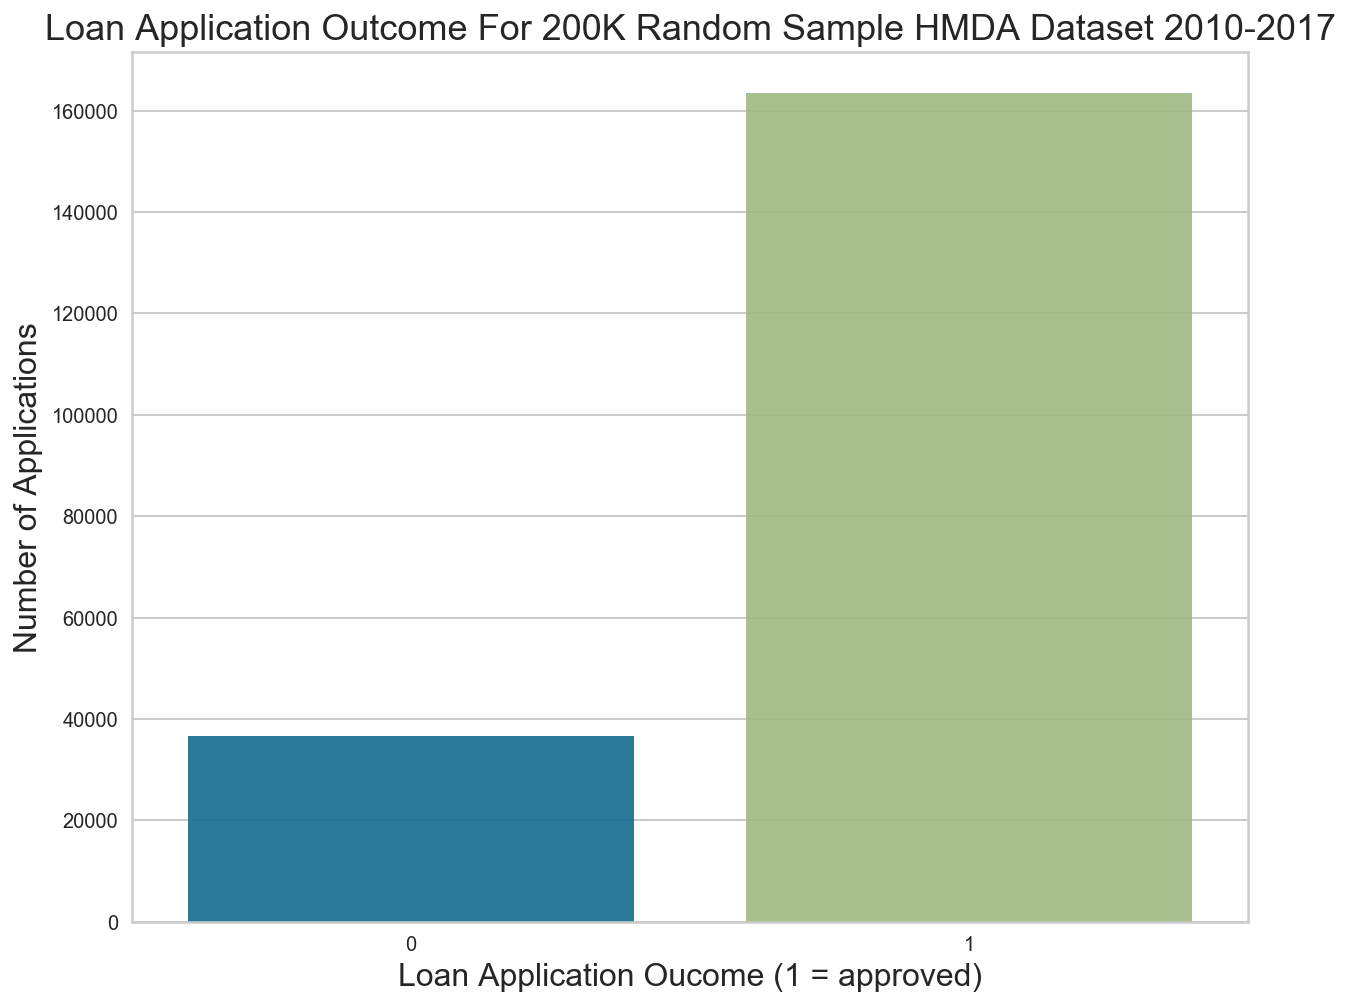

In [104]:
# Plotting and siple bar graph of loan application outcome:

loan_appl_outcome = df['action_taken'].value_counts()

plt.figure(figsize=(10,8))
sns.barplot(x=loan_appl_outcome.index, y=loan_appl_outcome.values, alpha = 0.9)

plt.title('Loan Application Outcome For 200K Random Sample HMDA Dataset 2010-2017', fontsize = 18)
plt.ylabel('Number of Applications', fontsize = 16)
plt.xlabel('Loan Application Oucome (1 = approved)', fontsize =16)
plt.xticks(rotation = 0)
plt.show()

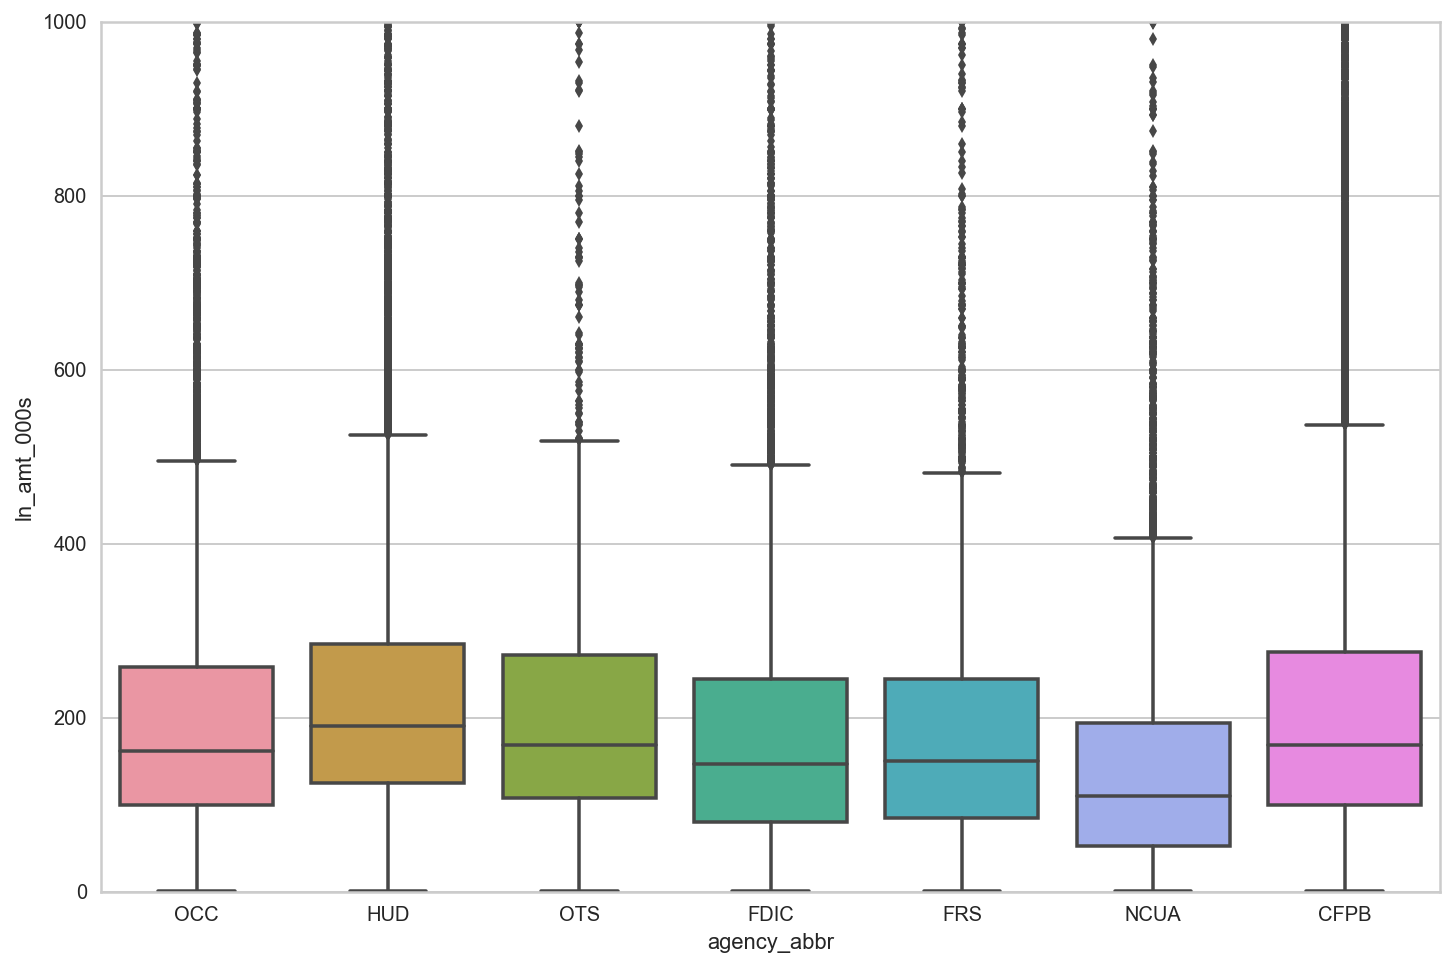

In [125]:
#Box plot
var = 'agency_abbr'
df = pd.concat([df['ln_amt_000s'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y='ln_amt_000s', data=df)
fig.axis(ymin=0, ymax=1000);

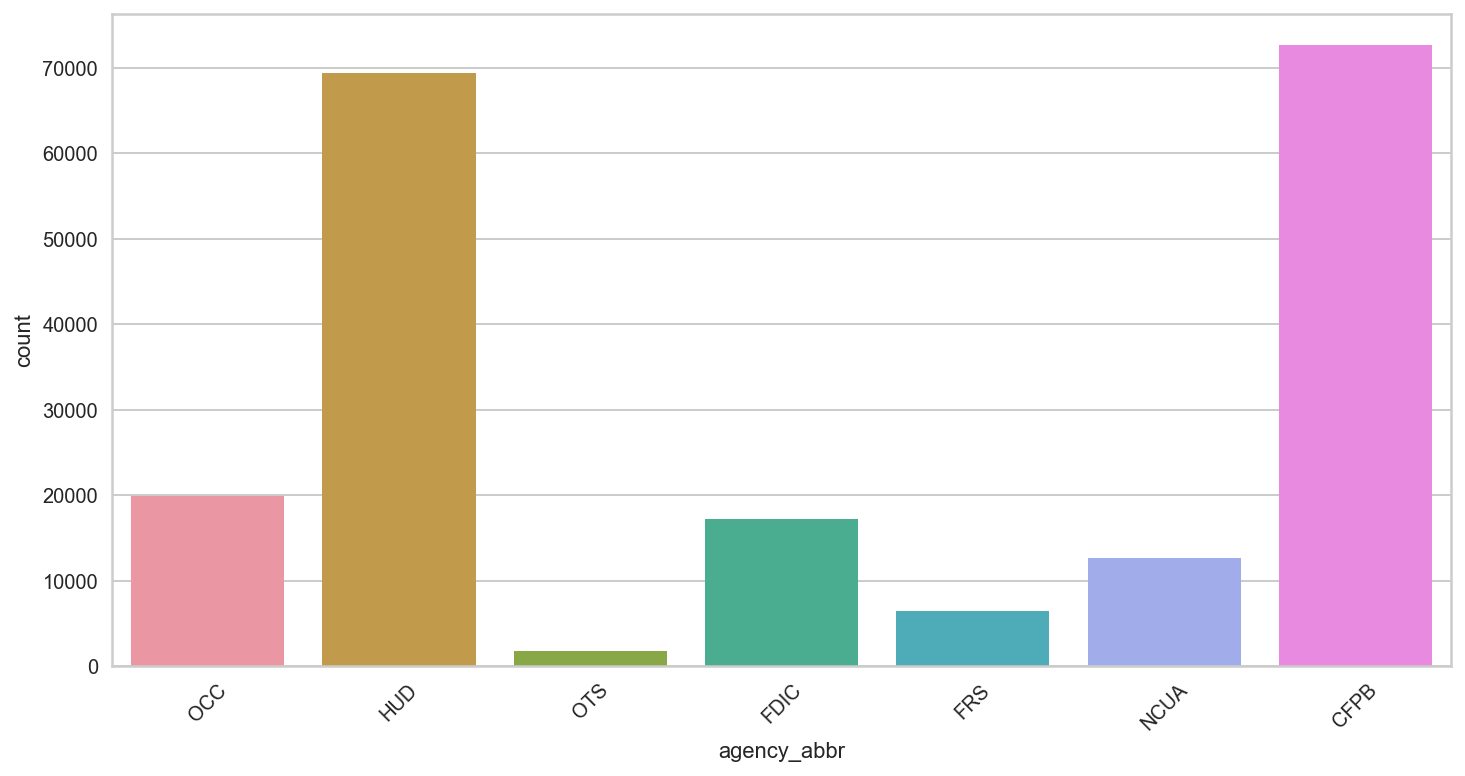

In [144]:
#Count Plot
plt.figure(figsize = (12, 6))
sns.countplot(x ='agency_abbr', data = df)
xt = plt.xticks(rotation=45)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a59387b38>,
      dtype=object)

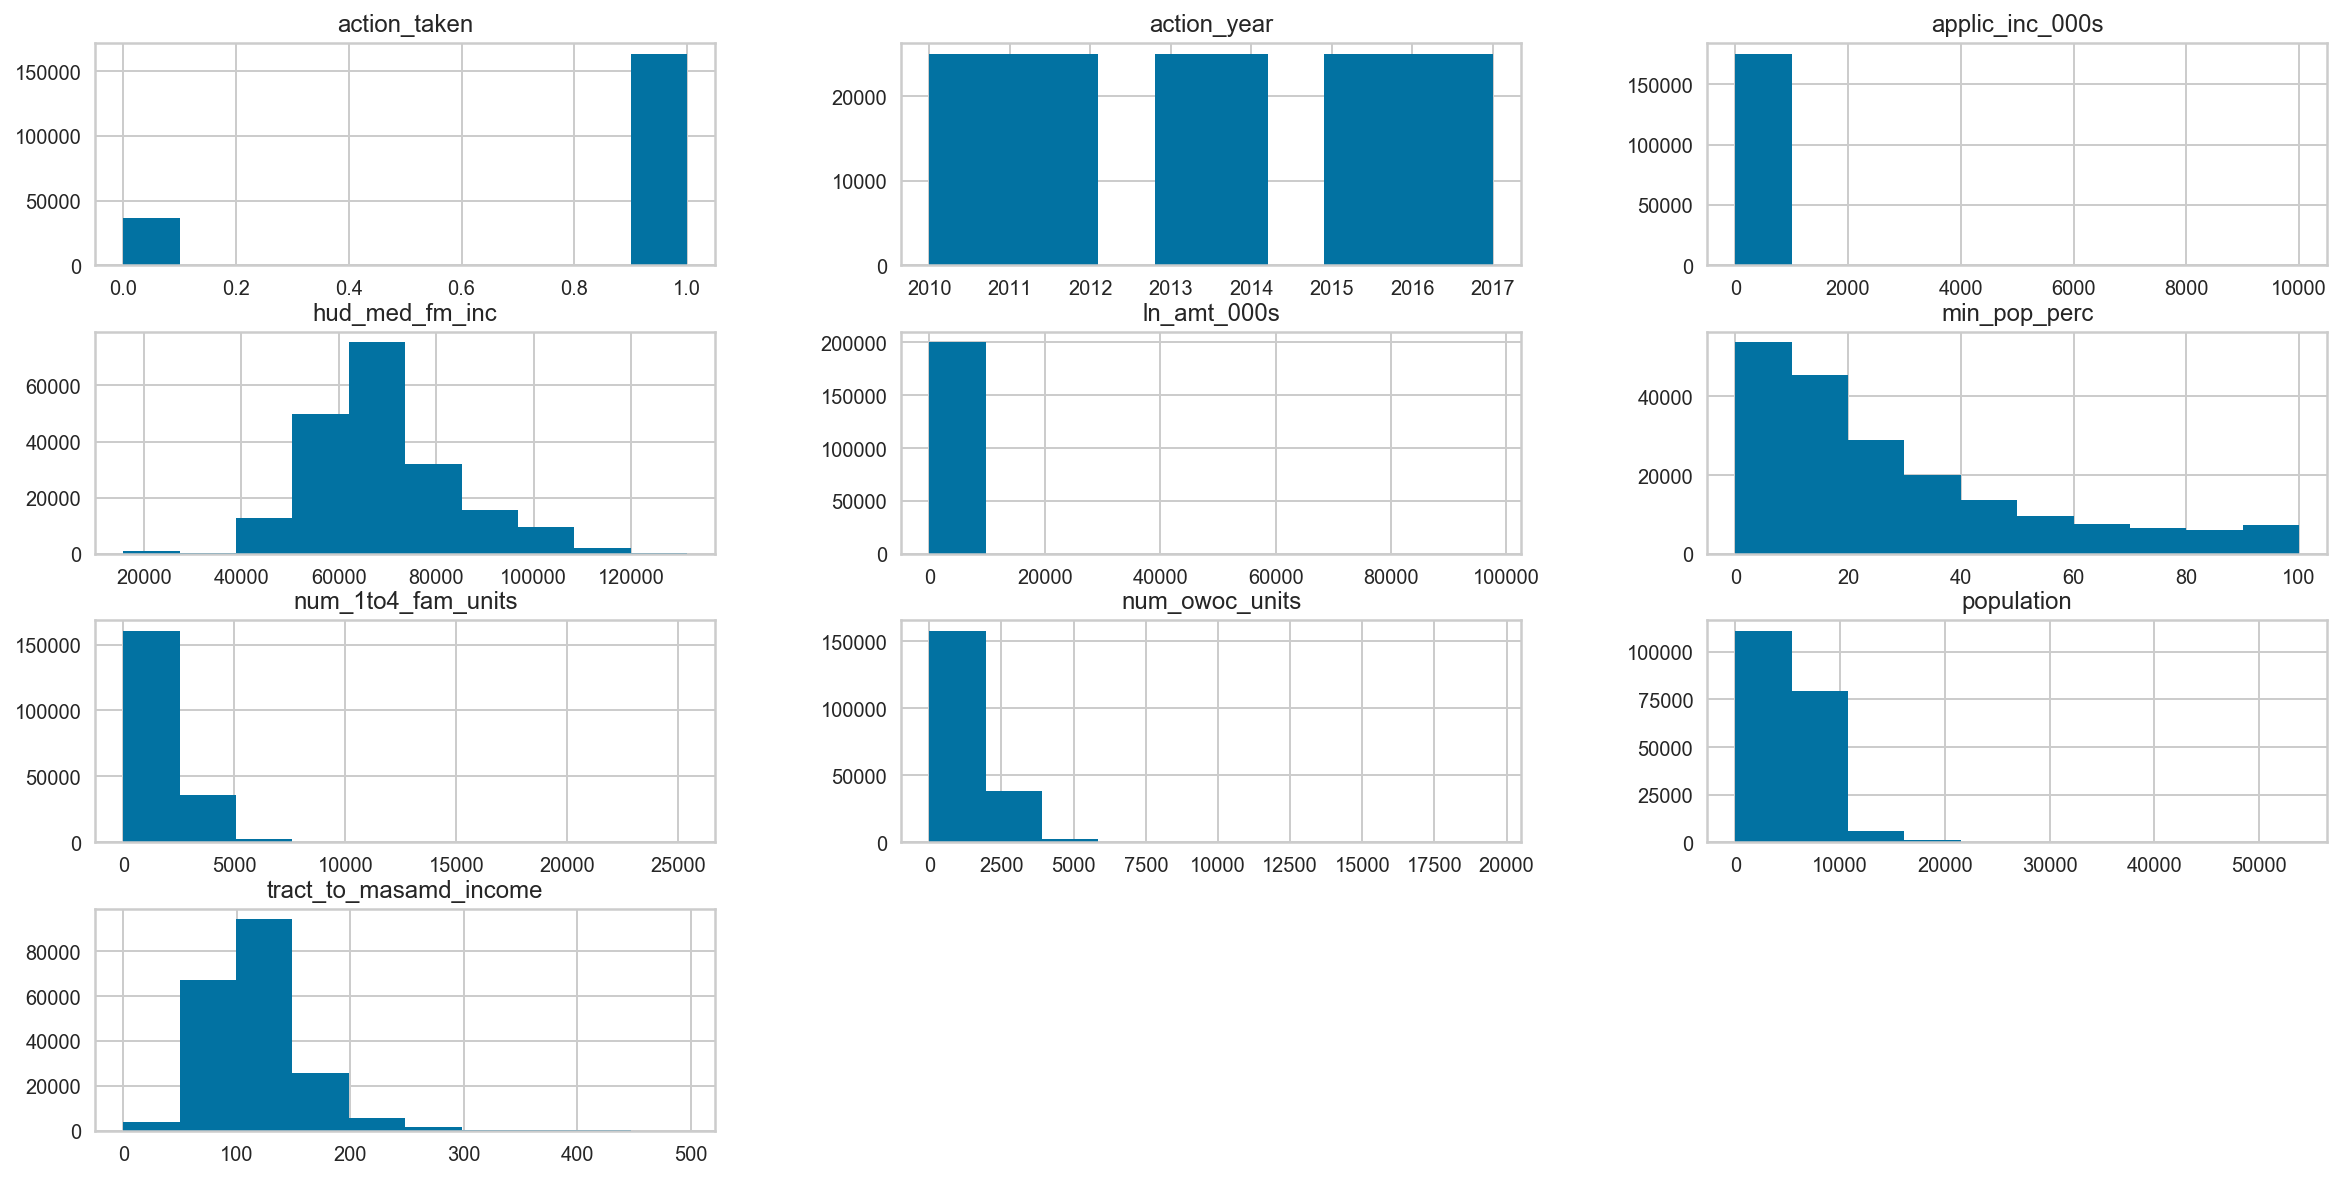

In [105]:
# Histogram for all features
df.hist(figsize=(20,10)) 

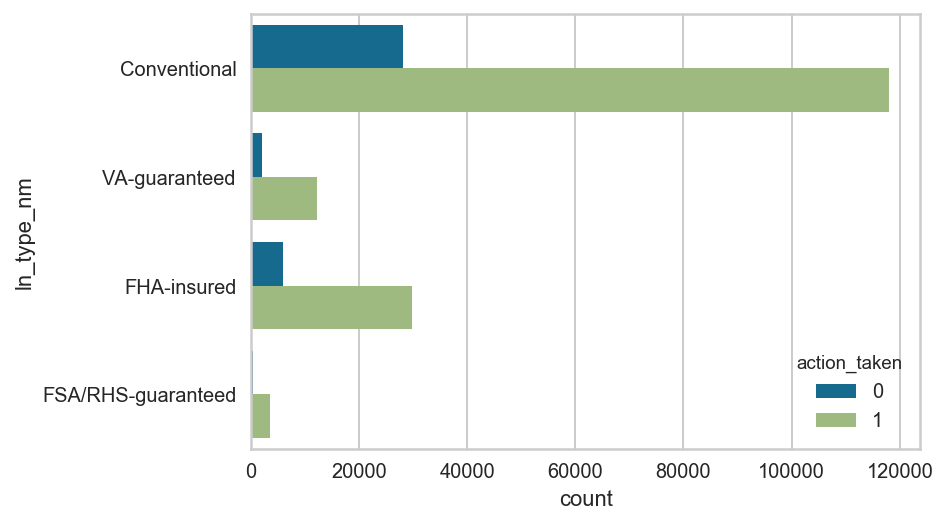

In [106]:
ax = sns.countplot(y='ln_type_nm', hue='action_taken', data=df,)

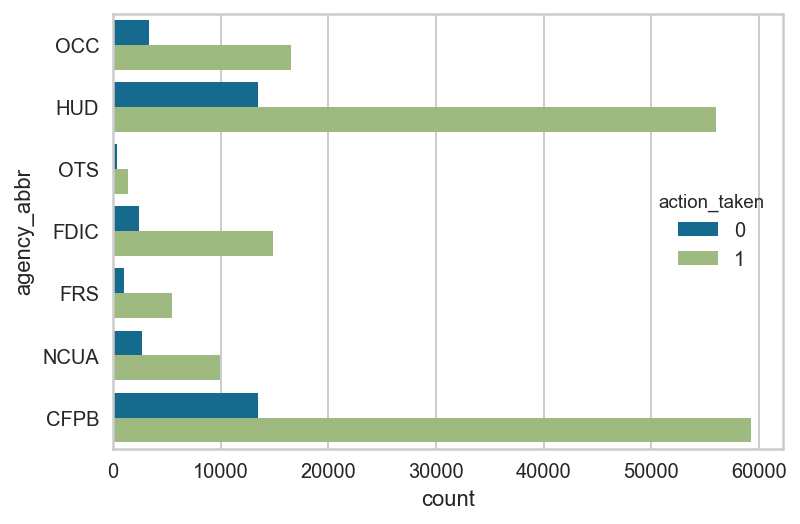

In [107]:
ax = sns.countplot(y='agency_abbr', hue='action_taken', data=df,)

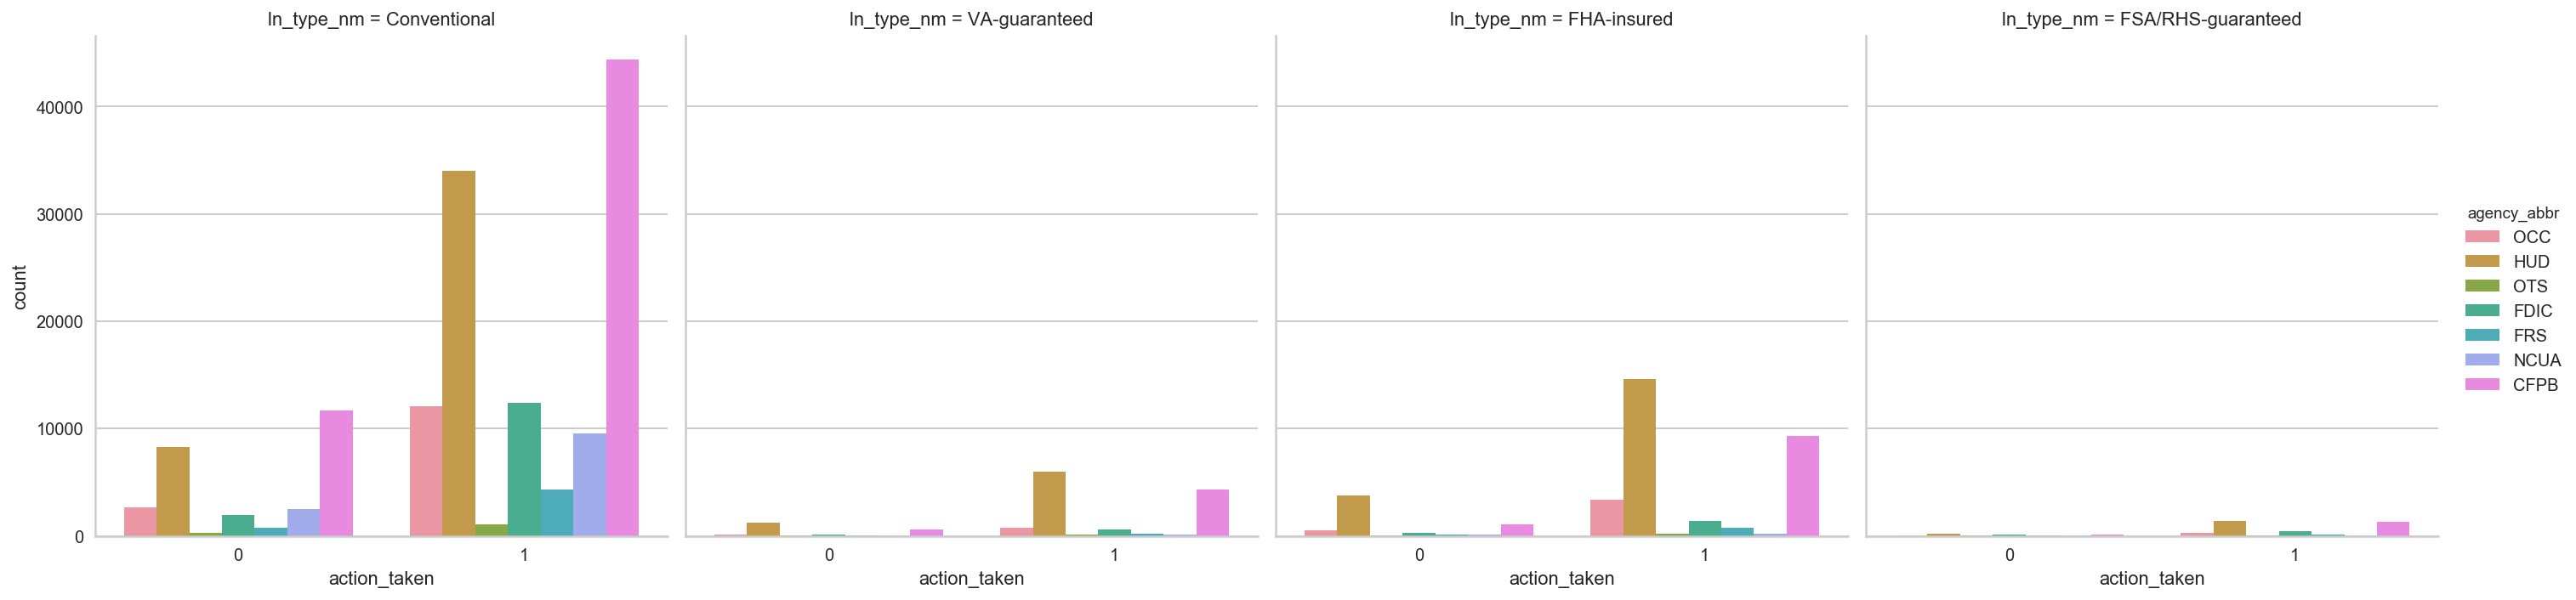

In [108]:
g = sns.catplot("action_taken", hue="agency_abbr",
                 col="ln_type_nm", data=df, kind = 'count')

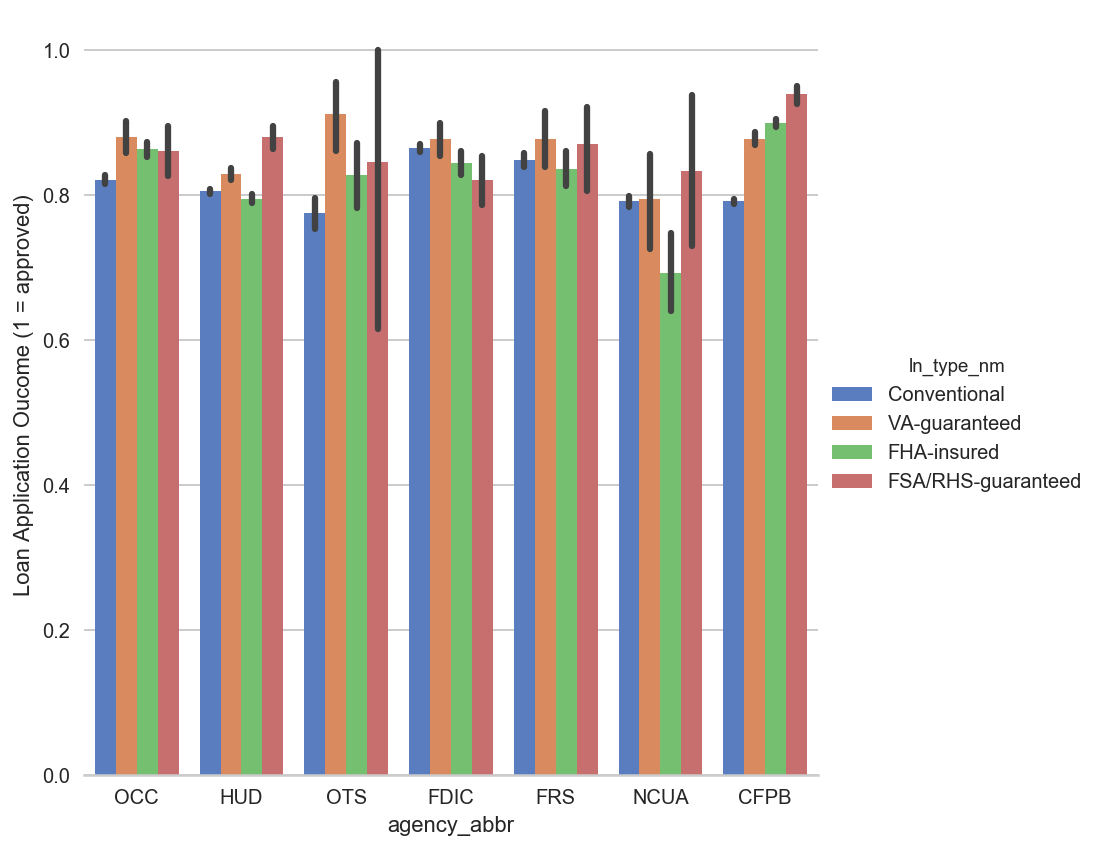

In [109]:
g = sns.catplot(x="agency_abbr",
                   y="action_taken", 
                   hue="ln_type_nm", 
                   data=df,
                   height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Loan Application Oucome (1 = approved)") 

TypeError: ylabel() missing 1 required positional argument: 'ylabel'

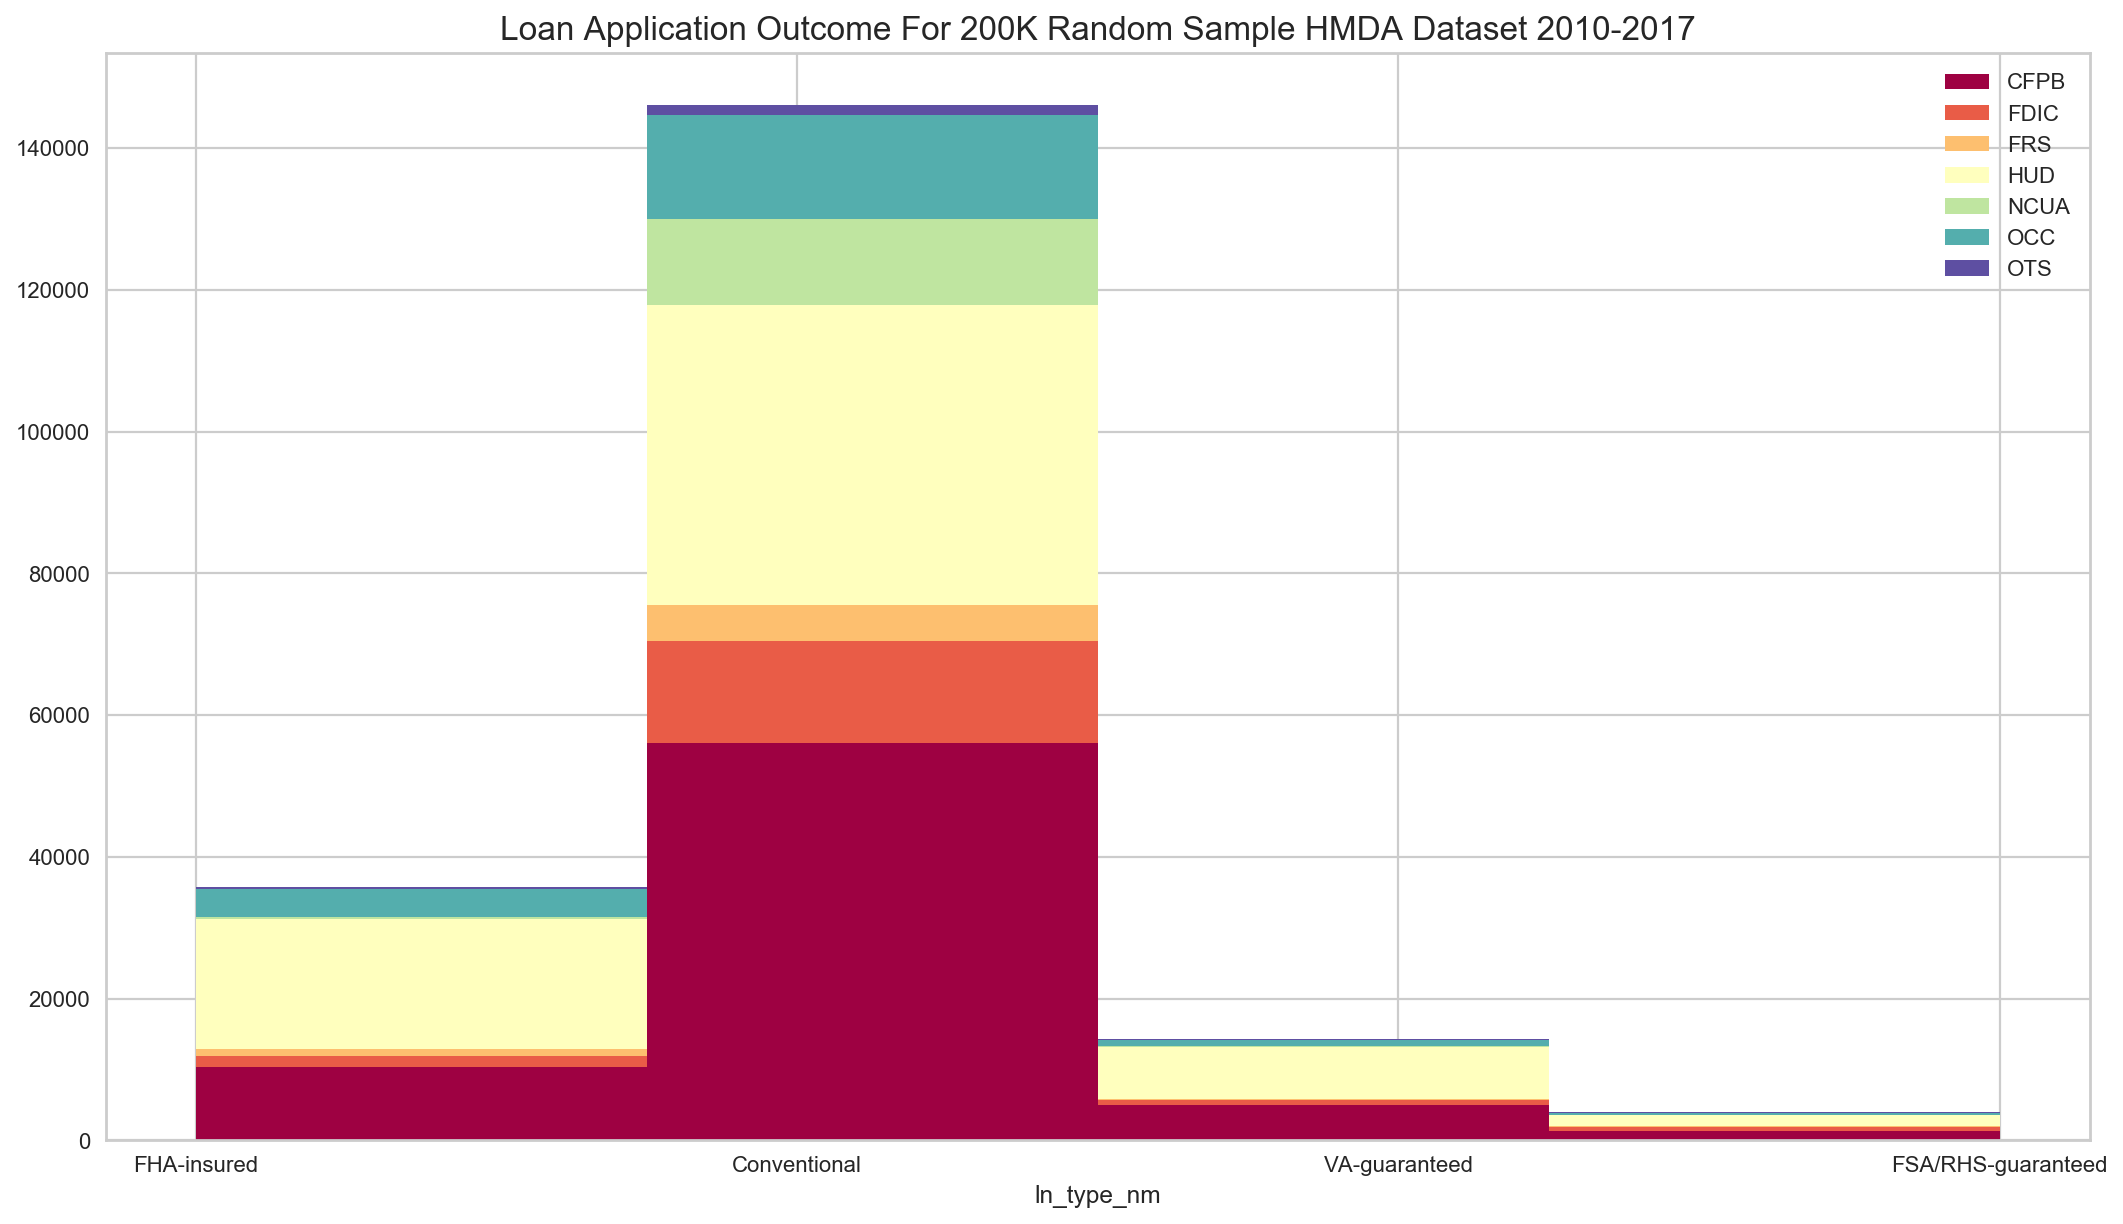

In [111]:
### Histogram for Categorical Variable
x = 'ln_type_nm'
y = 'agency_abbr'
df_agg = df.loc[:, [x,y]].groupby(y)
vals = [df[x].values.tolist() for i, df in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, df[x].unique().__len__(), stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df[y]).tolist(), colors[:len(vals)])})
plt.title('Loan Application Outcome For 200K Random Sample HMDA Dataset 2010-2017', fontsize=15)
plt.xlabel('ln_type_nm')
plt.ylabel()
plt.ylim(0, 20)
plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
plt.show()

In [112]:
df.shape

(200000, 21)

In [114]:
#numerical features in the dataset
numeric_features = df.select_dtypes(include=[np.number])

numeric_features.columns

Index(['action_taken', 'action_year', 'tract_to_masamd_income', 'population',
       'min_pop_perc', 'num_owoc_units', 'num_1to4_fam_units', 'ln_amt_000s',
       'hud_med_fm_inc', 'applic_inc_000s'],
      dtype='object')

In [115]:
#categorical_features in the dataset
categorical_features = df.select_dtypes(include=[np.object])
categorical_features.columns

Index(['own_occ_nm', 'ln_type_nm', 'lien_status_nm', 'hoep_status_nm',
       'co_appl_sex', 'co_appl_race', 'co_appl_ethn', 'applic_sex',
       'applic_race', 'applic_ethn', 'agency_abbr'],
      dtype='object')

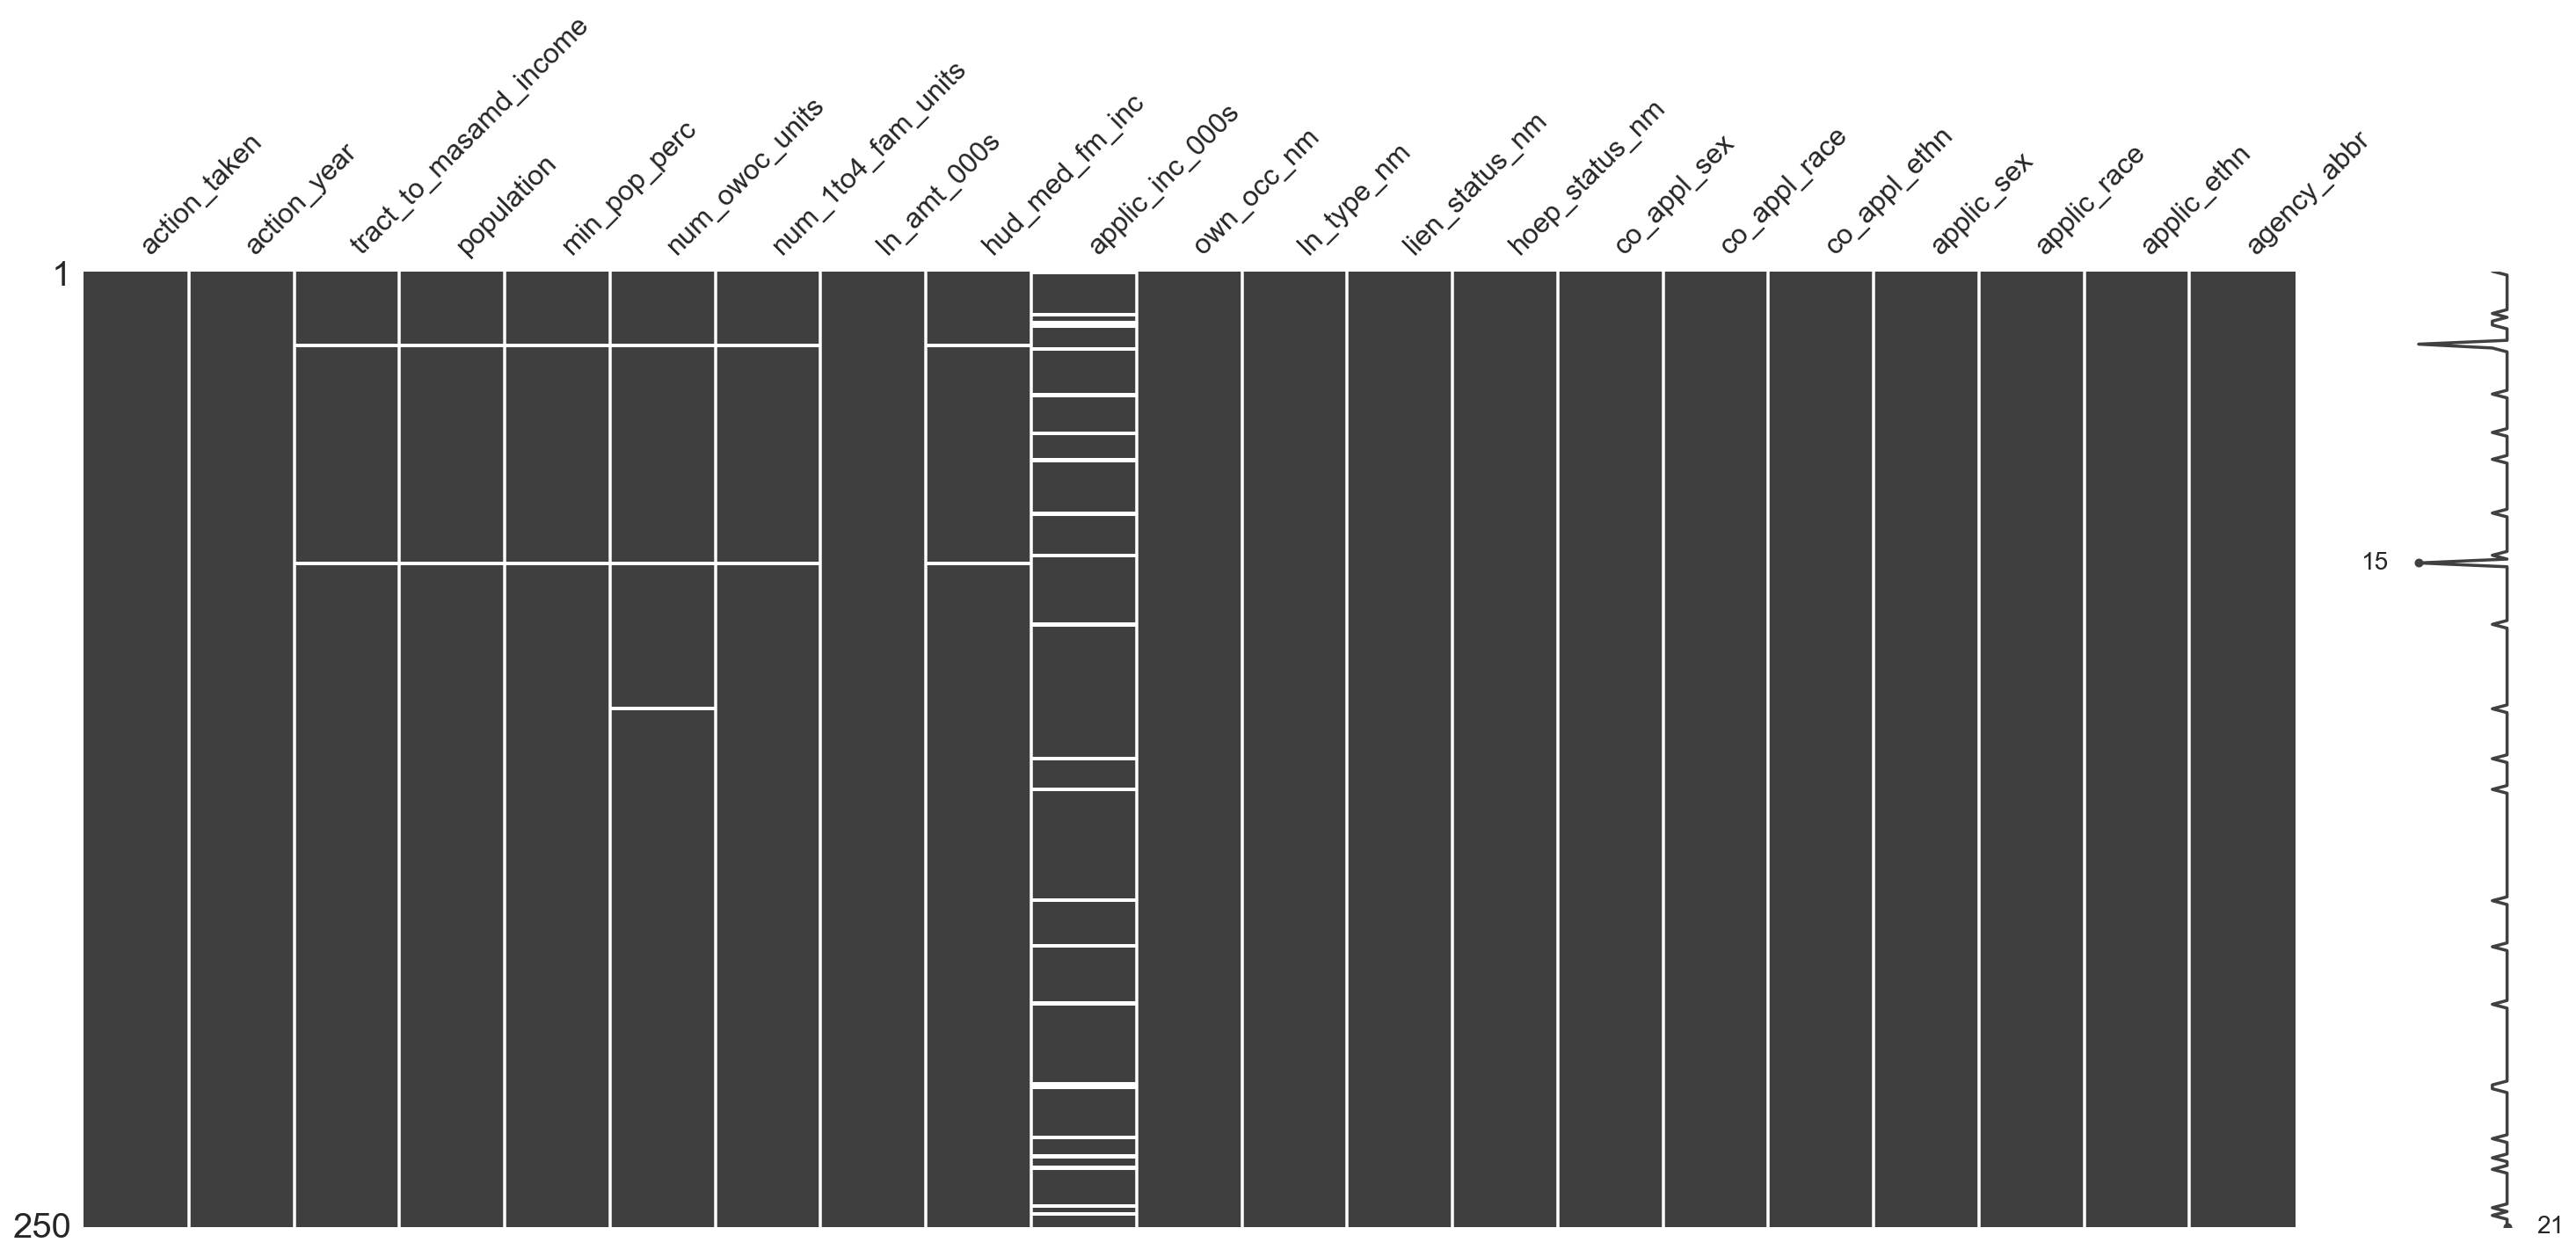

In [116]:
#Visualising missing values for a sample of 250
import missingno as msno
msno.matrix(df.sample(250))

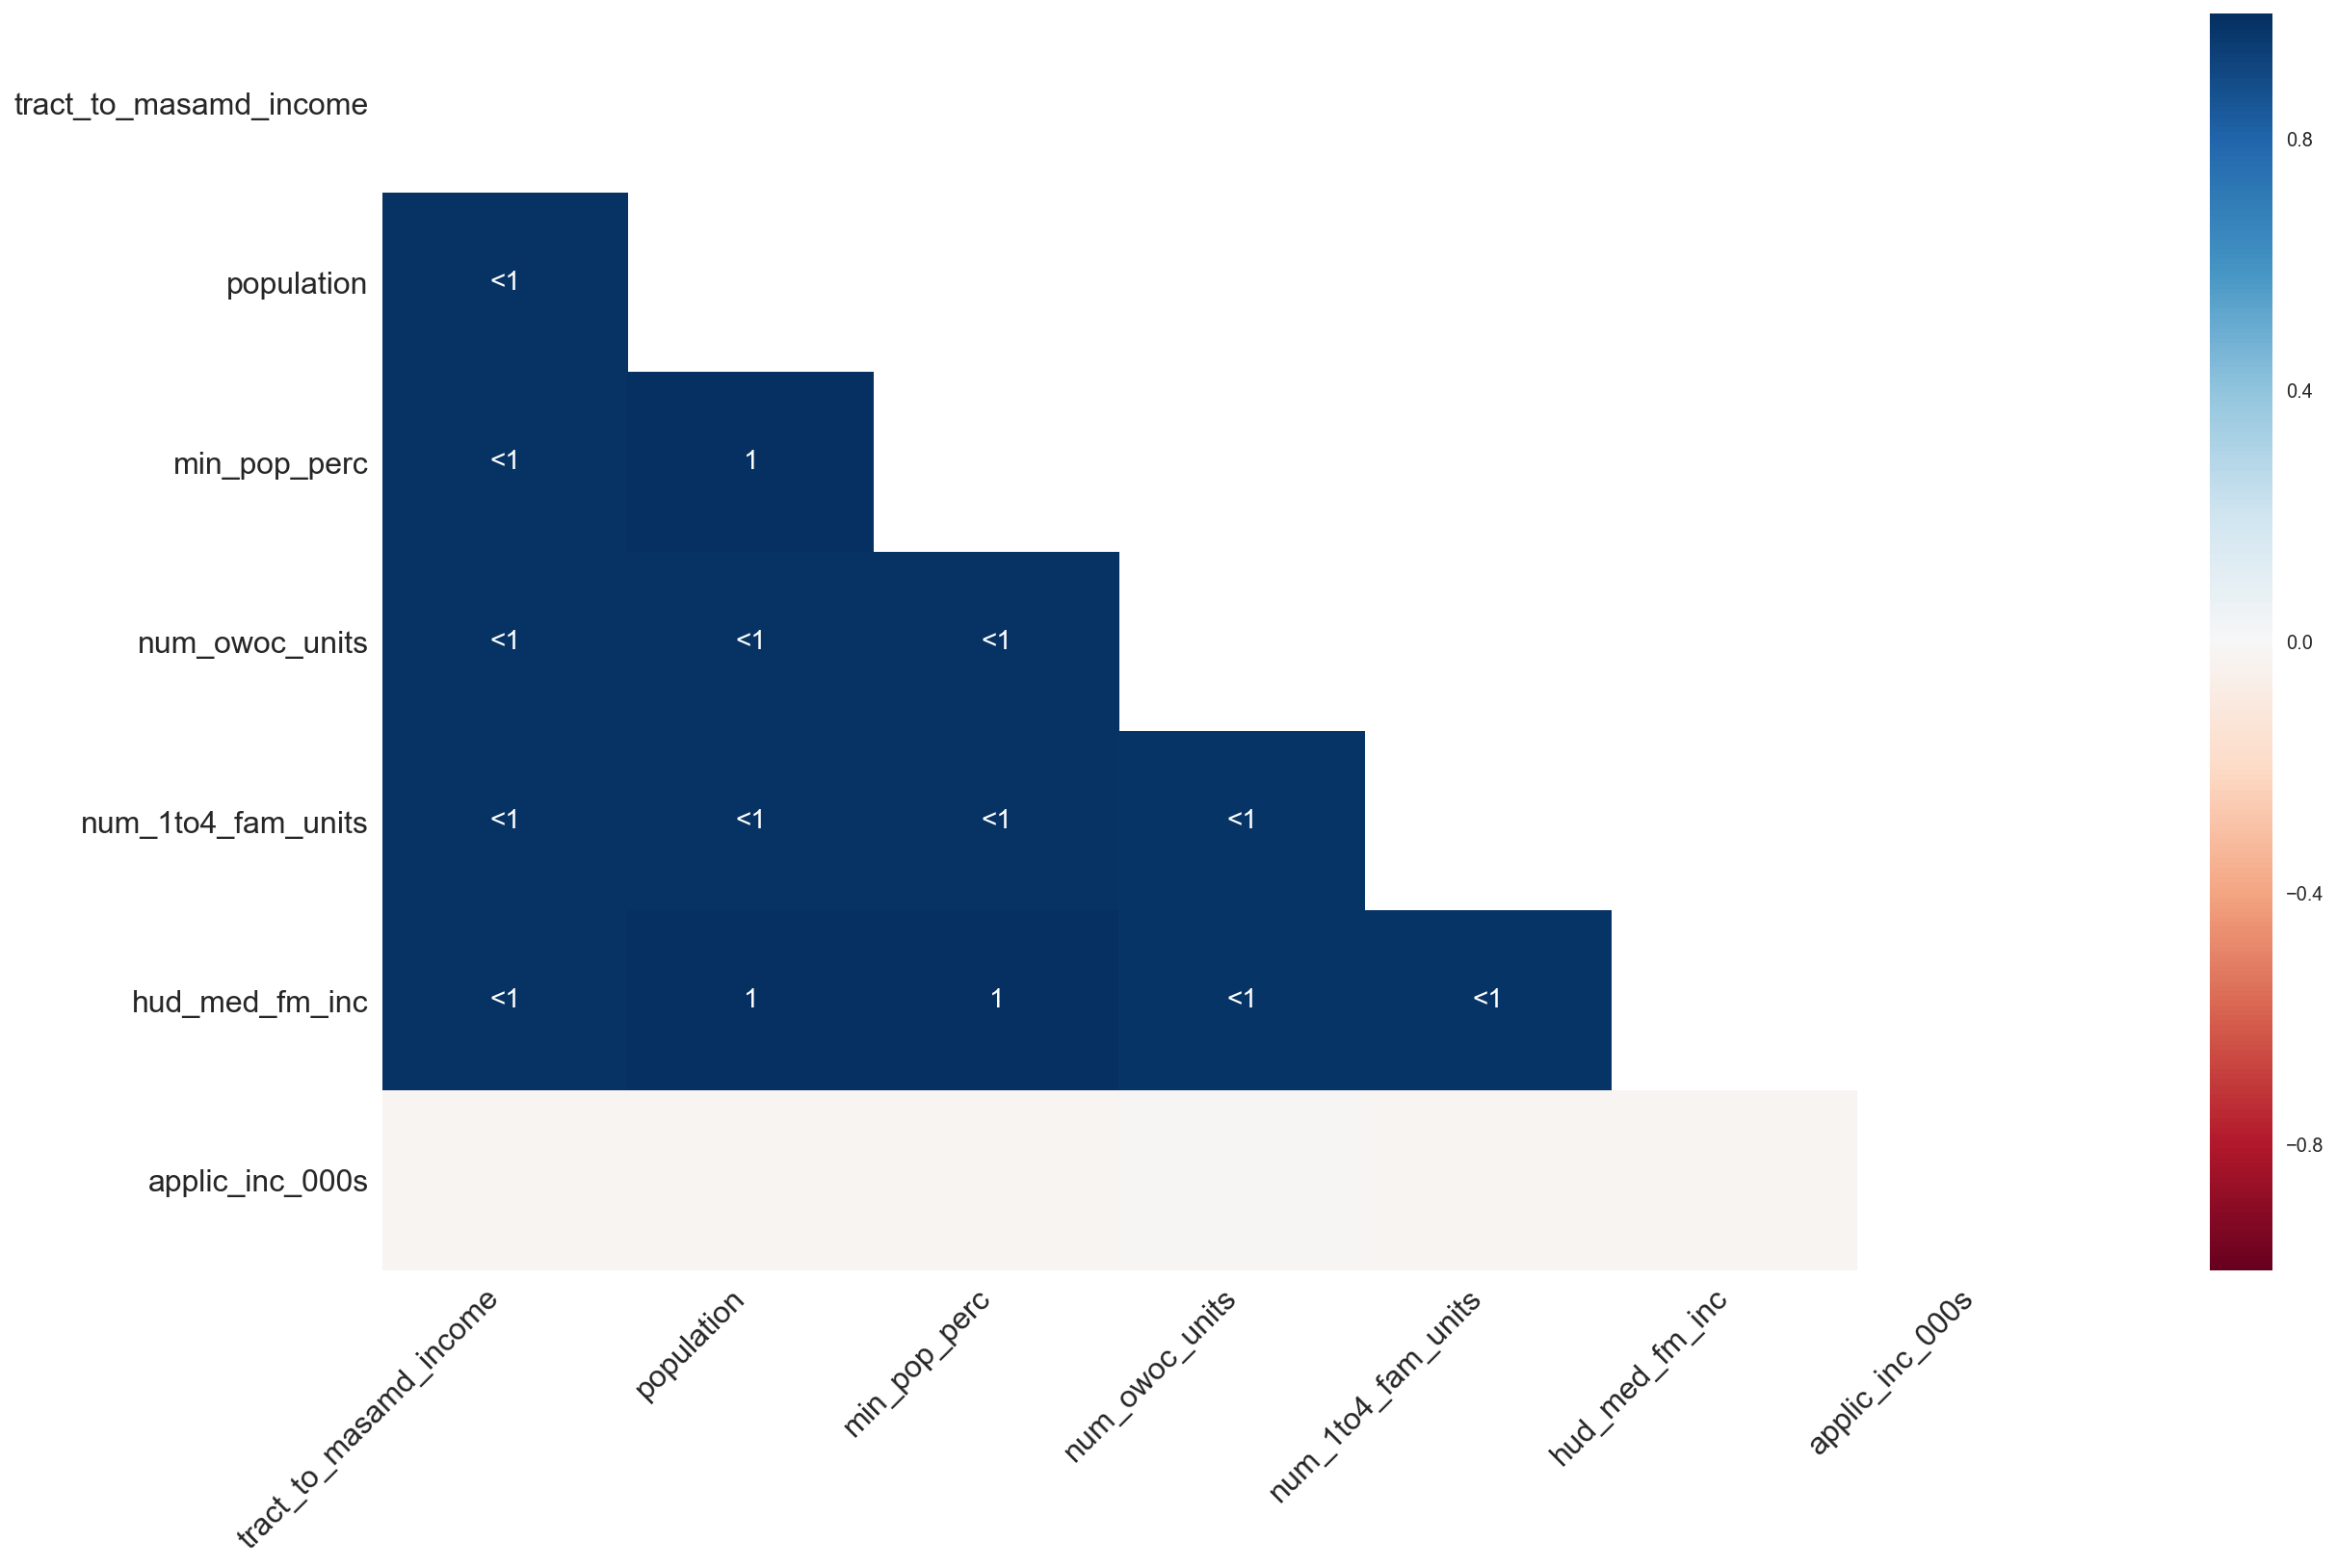

In [75]:
#Heatmap 
msno.heatmap(df)

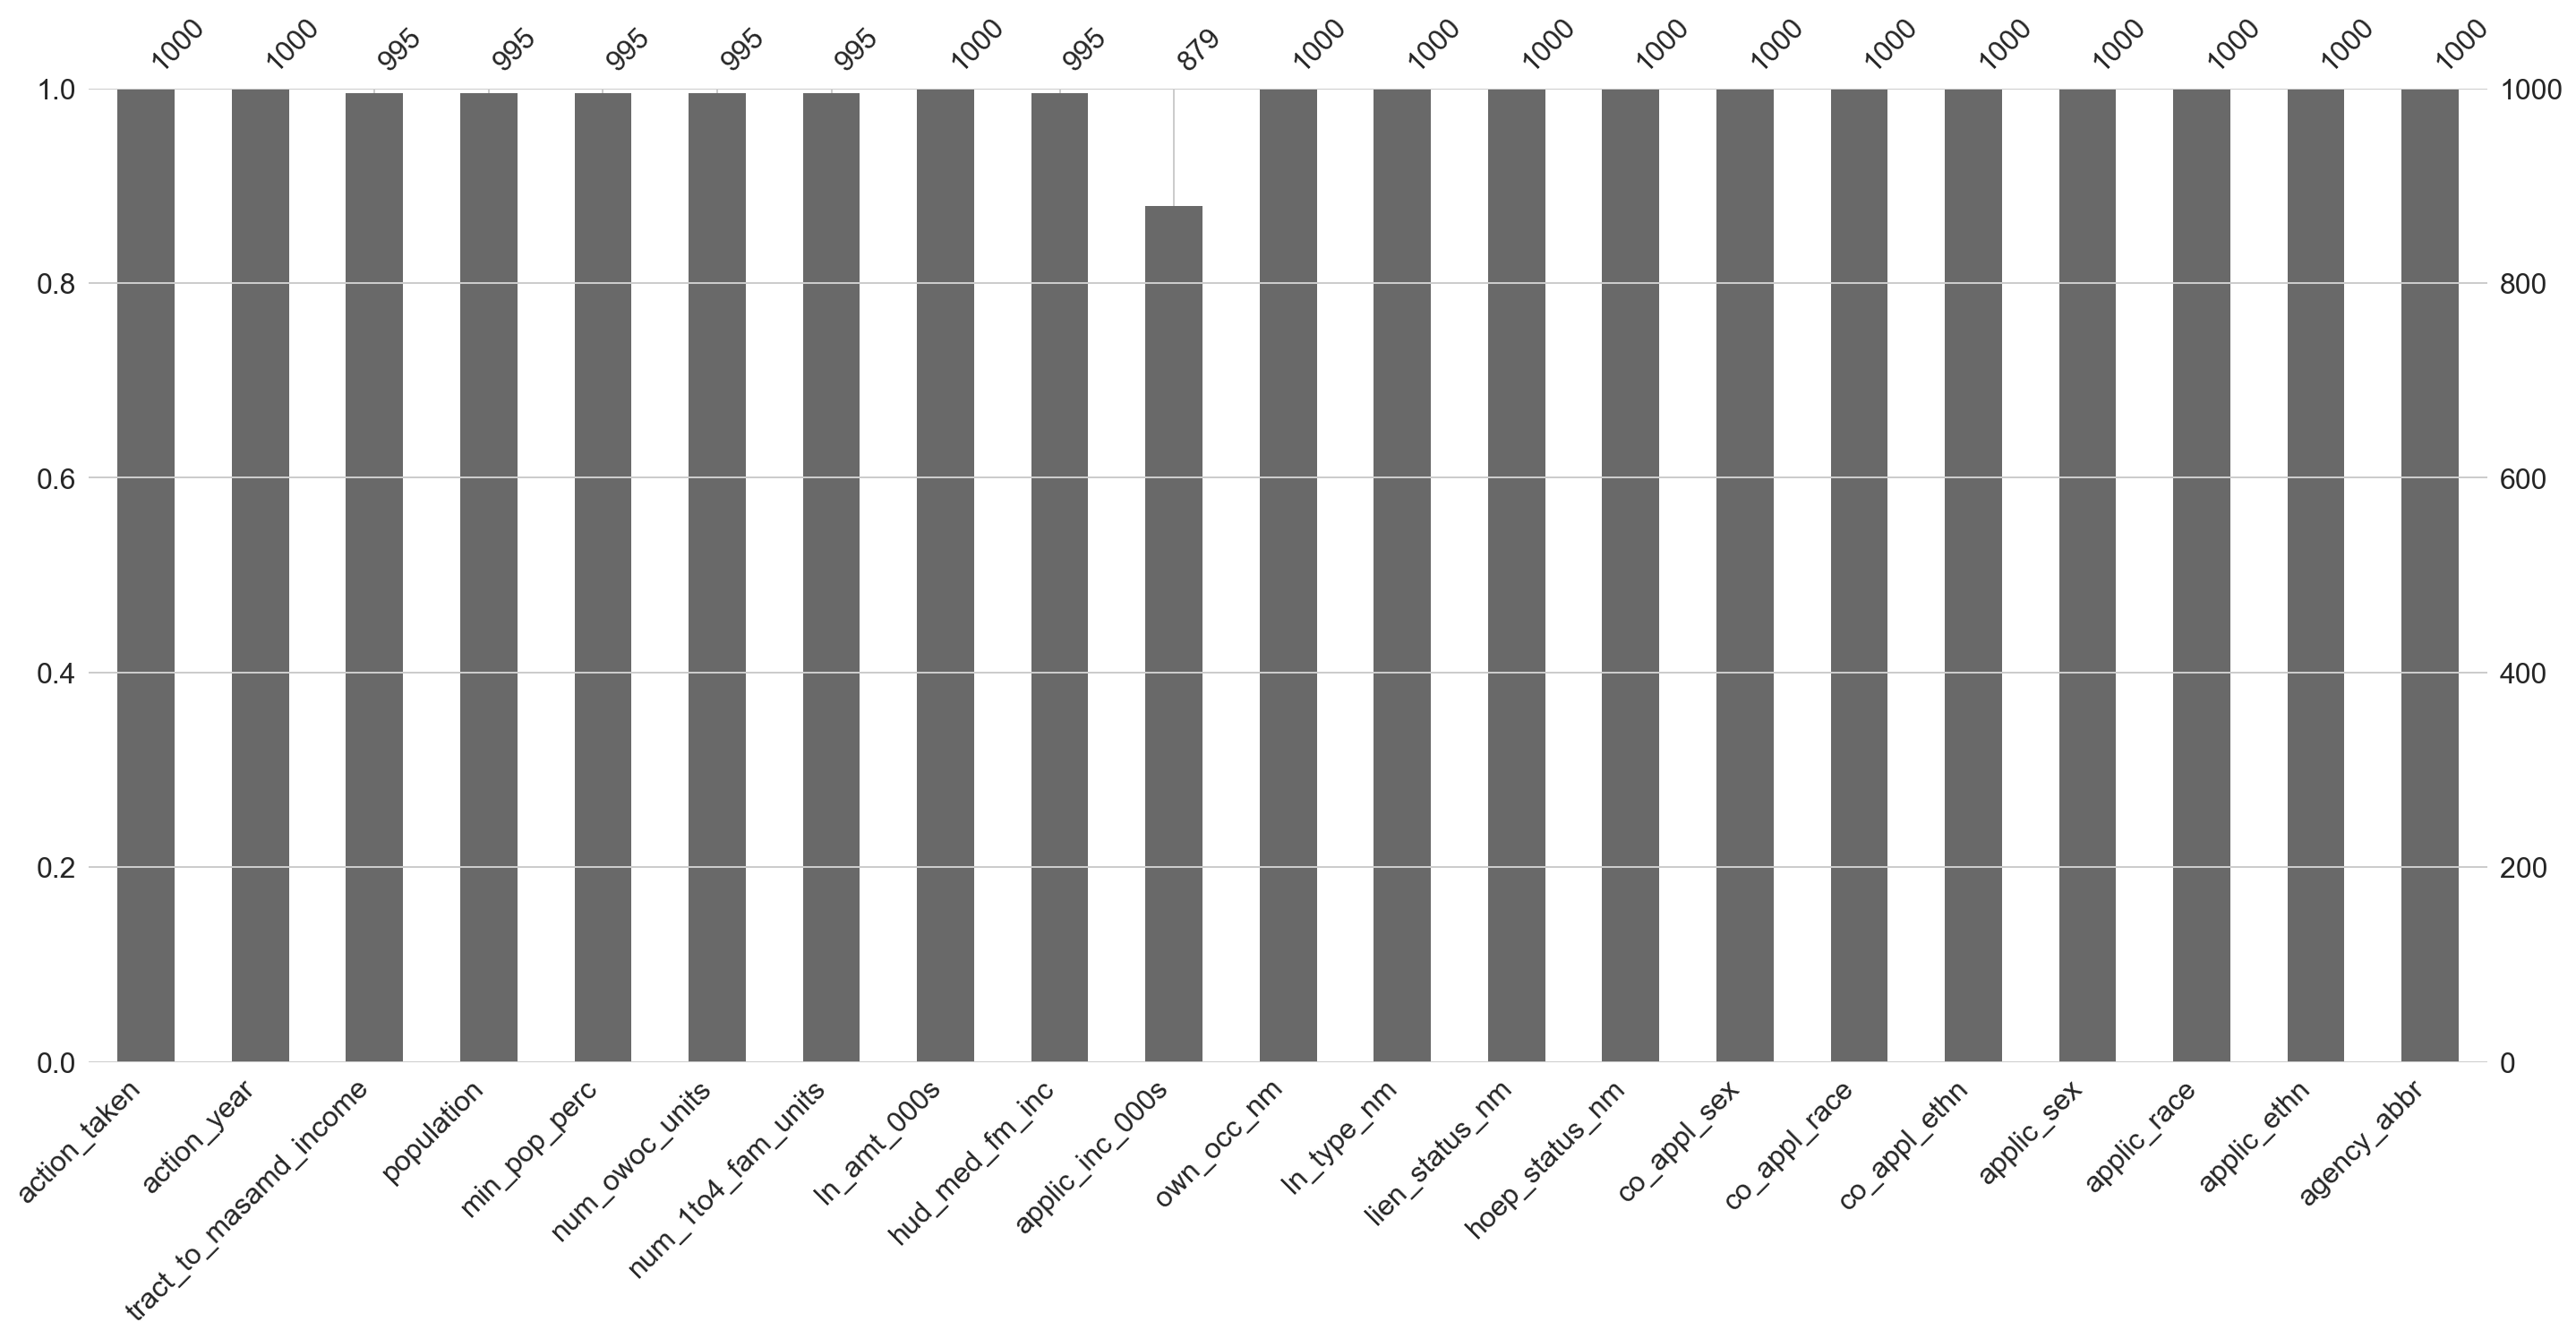

In [76]:
msno.bar(df.sample(1000))

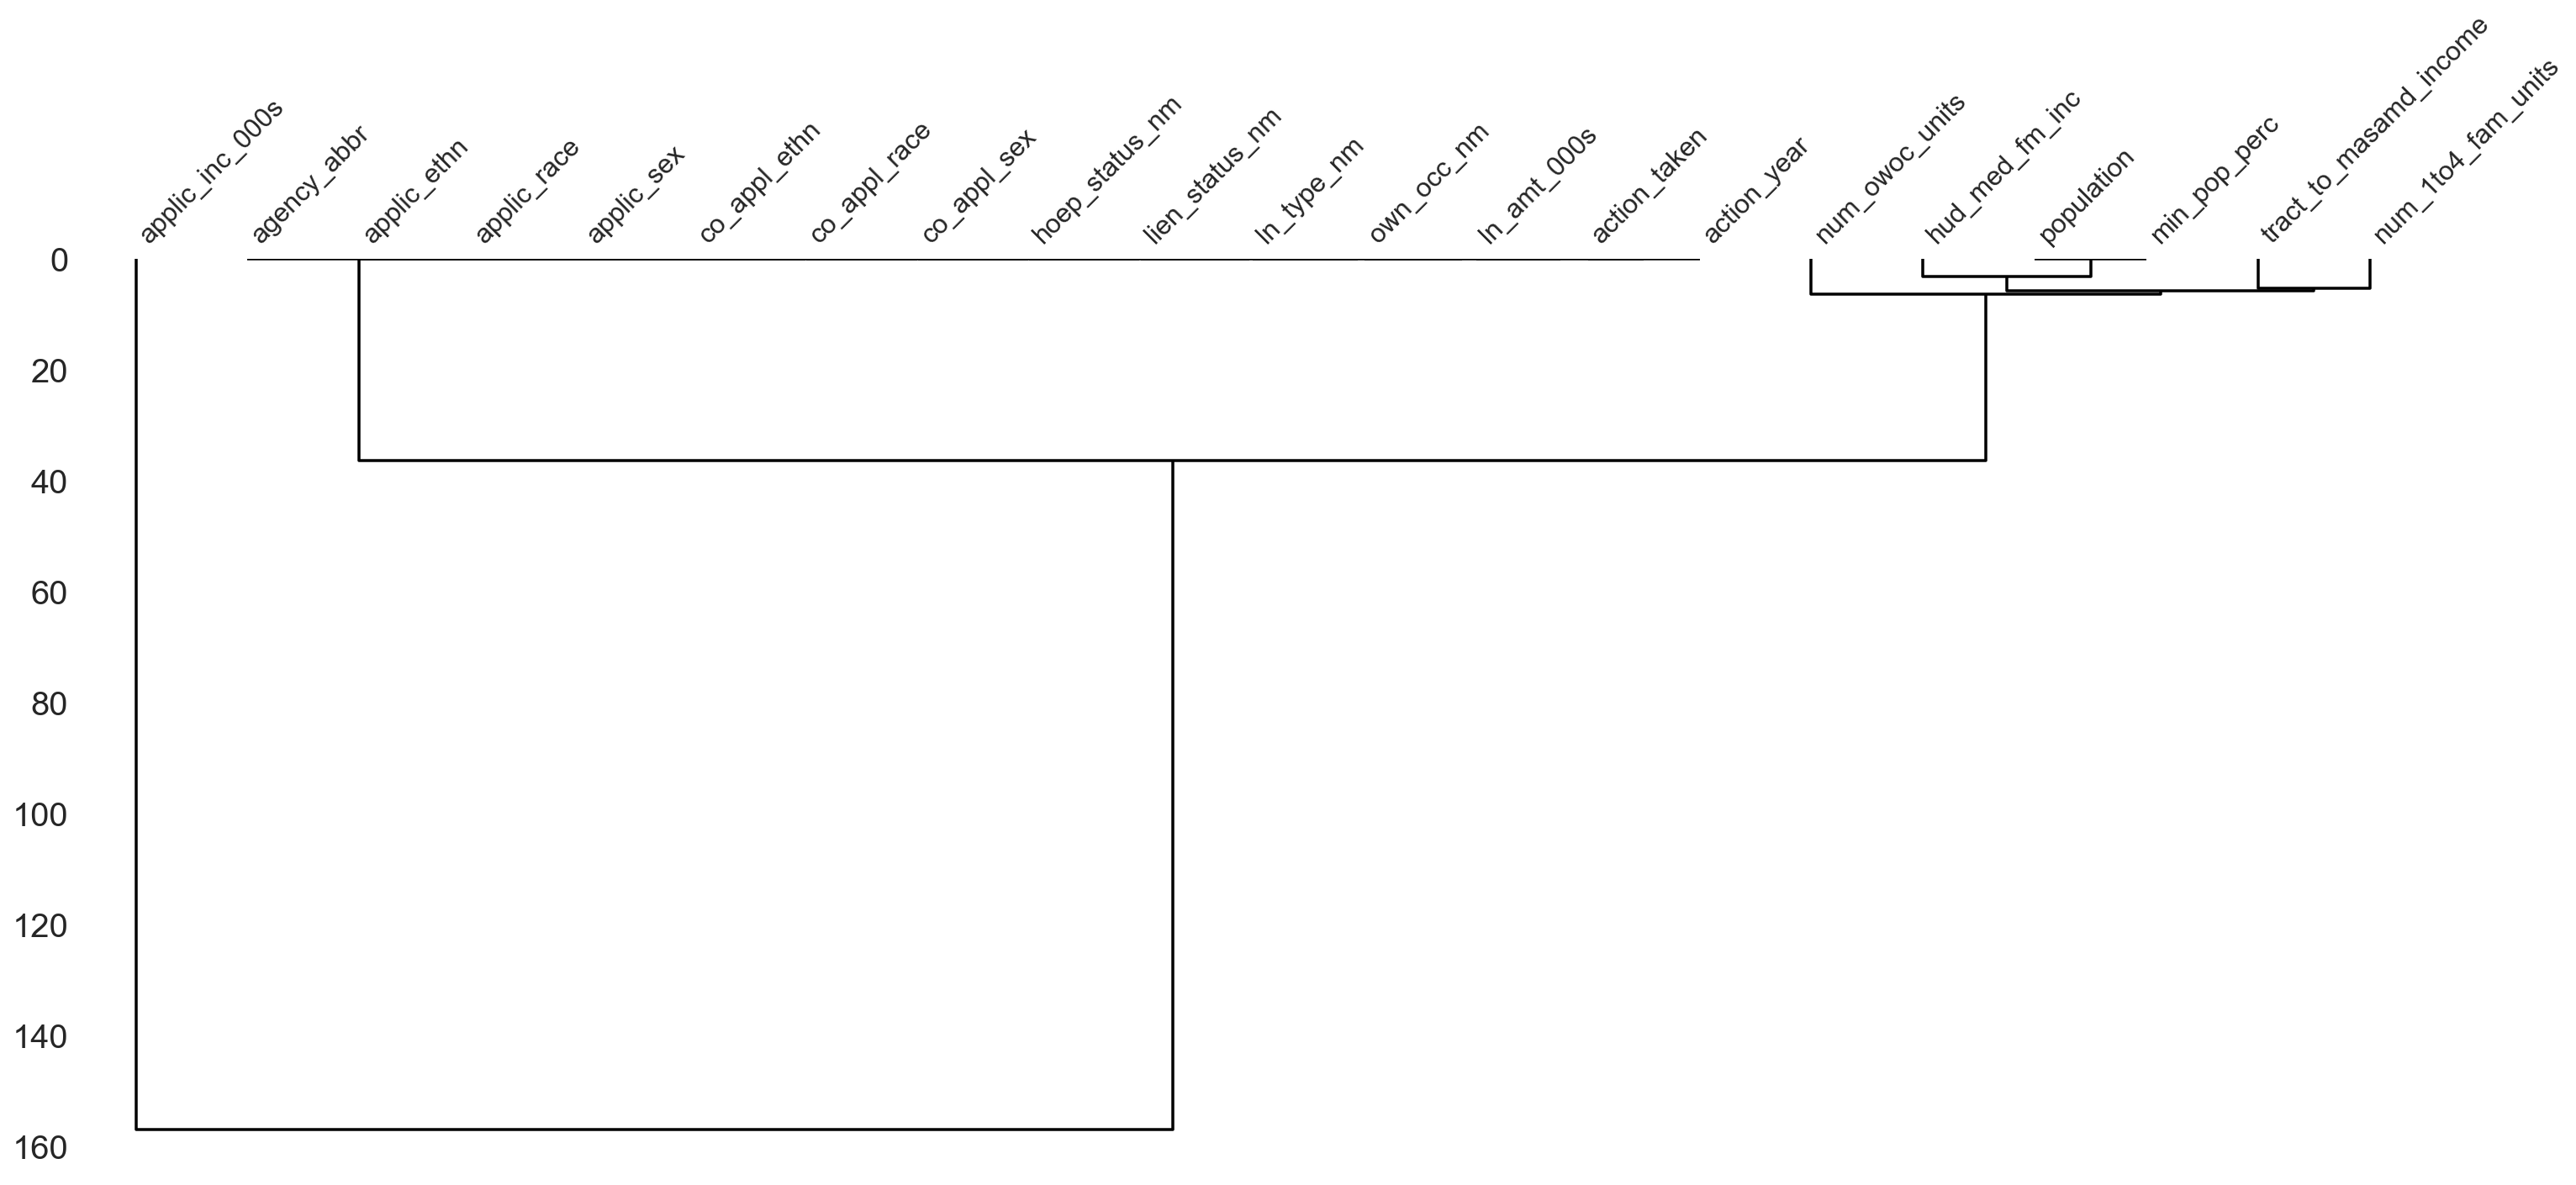

In [77]:
## Dendrogram
msno.dendrogram(df)

In [80]:
#Skewness 
df.skew()

action_taken              -1.641486
action_year                0.000000
tract_to_masamd_income     1.387999
population                 2.823531
min_pop_perc               1.183885
num_owoc_units             2.196951
num_1to4_fam_units         2.231142
ln_amt_000s               88.968450
hud_med_fm_inc             0.666941
applic_inc_000s           23.118067
dtype: float64

In [64]:
# Feature Analysis Imports 
from yellowbrick.features import JointPlotVisualizer
from yellowbrick.features import Rank1D, Rank2D

<Figure size 800x640 with 0 Axes>

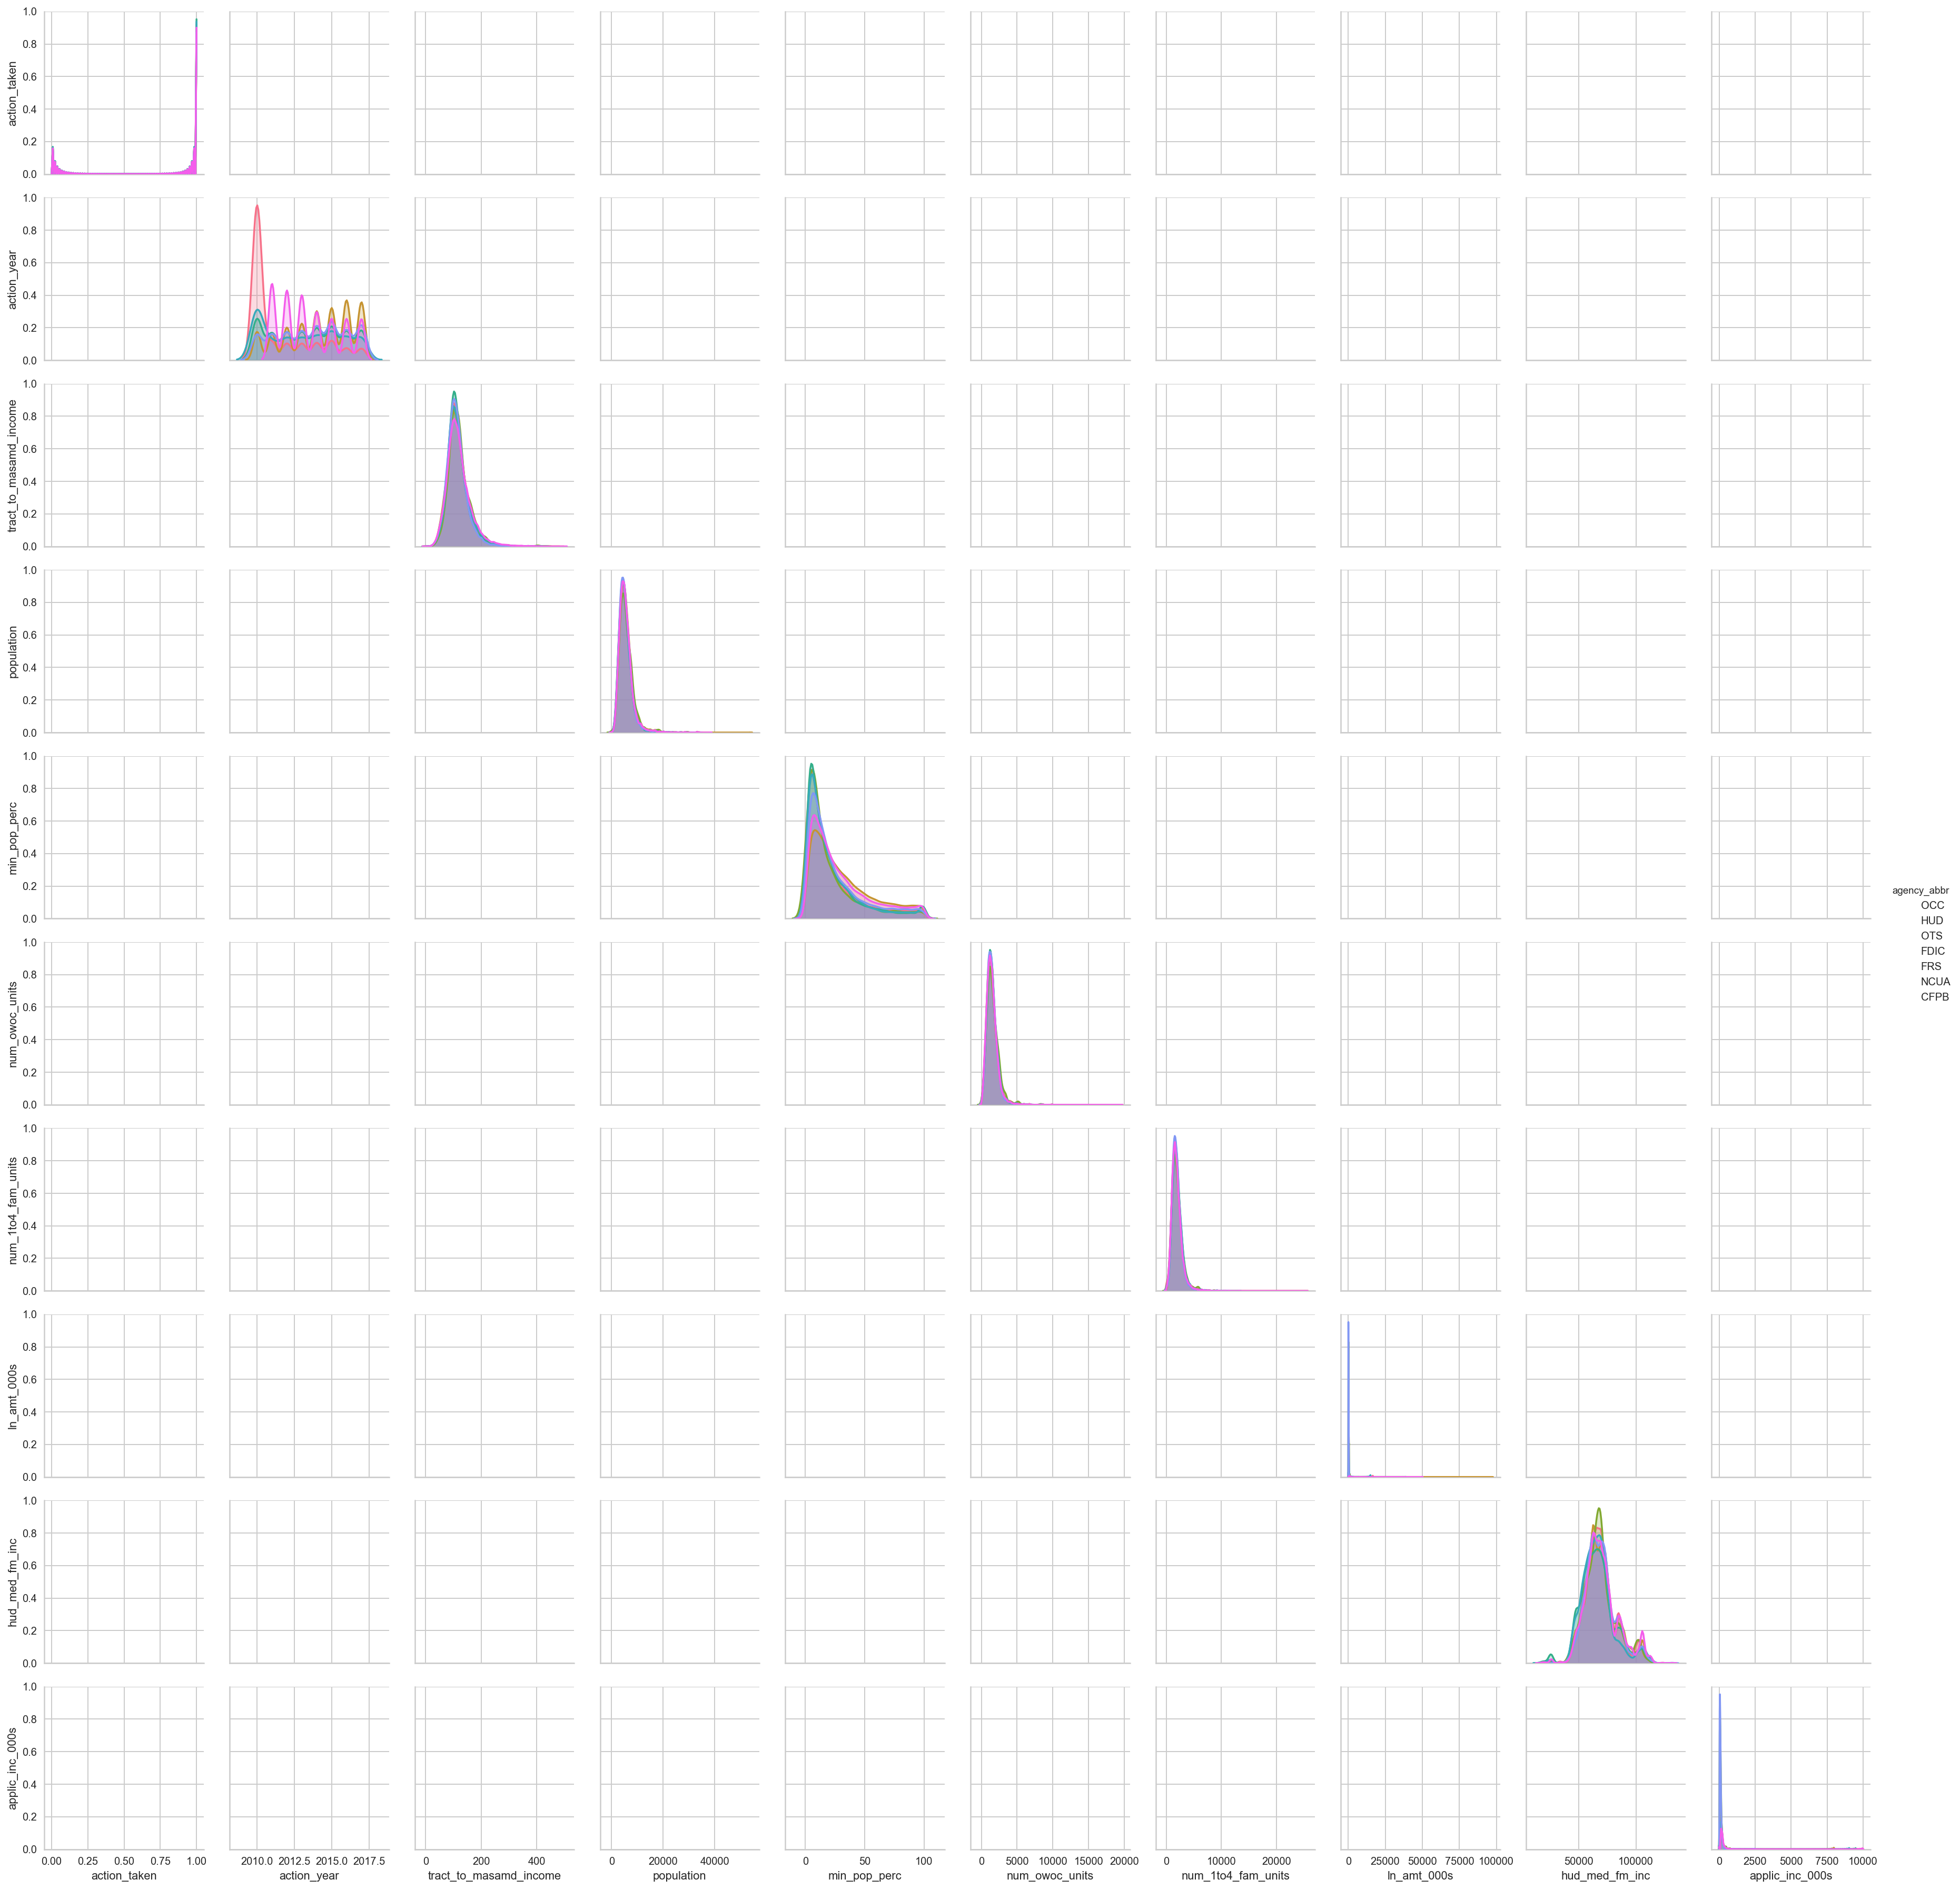

In [110]:
#Pairwise plot 
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df, kind="action_taken", hue="agency_abbr", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

### Rank Features


In [143]:
# Specify the features of interest
features = ['action_taken', 'action_year', 'tract_to_masamd_income', 'population',
       'min_pop_perc', 'num_owoc_units', 'num_1to4_fam_units', 'ln_amt_000s',
       'hud_med_fm_inc', 'applic_inc_000s'
            
           ]


#Extract the numpy arrays from the data frame 
X = df[features]
y = df.action_taken

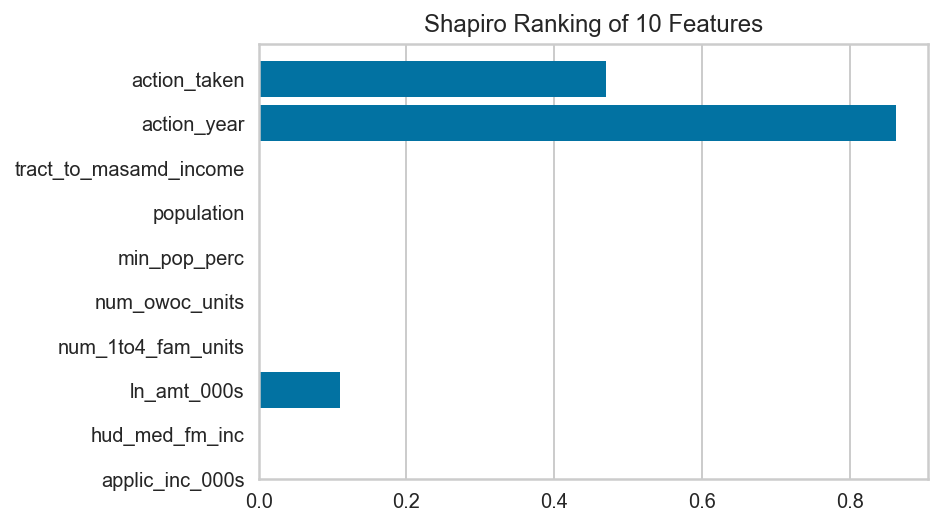

In [141]:
#Instantiate the visualizer with the Covariance ranking algorithm 
visualizer = Rank1D(features=features , algorithm='shapiro')

visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof()                   # Draw/show/poof the data

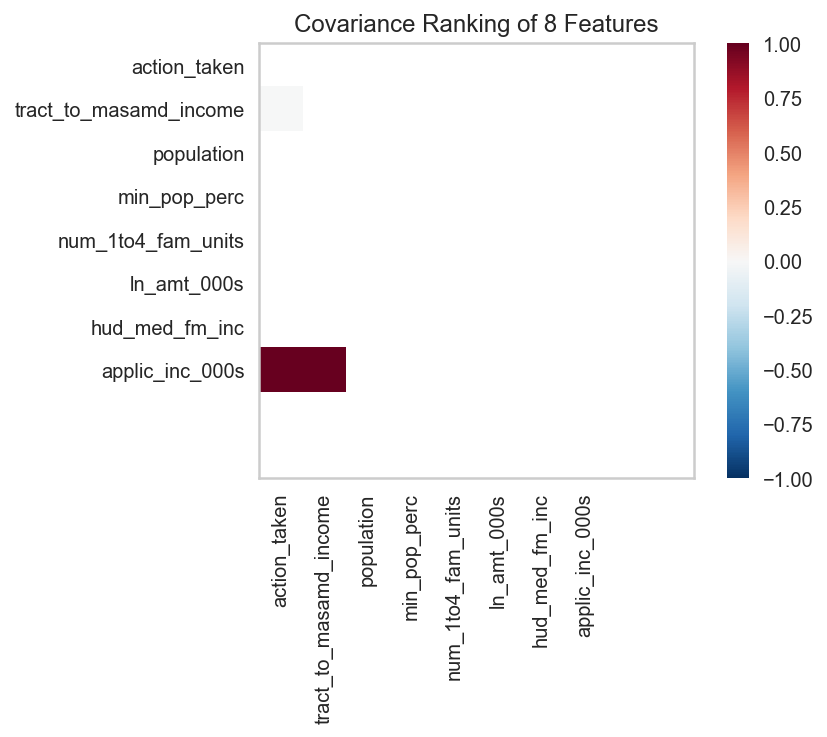

In [136]:
# Instantiate the visualizer with the Covariance ranking algorithm 
visualizer = Rank2D(features=features, algorithm='covariance')

visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof()                   # Draw/show/poof the data

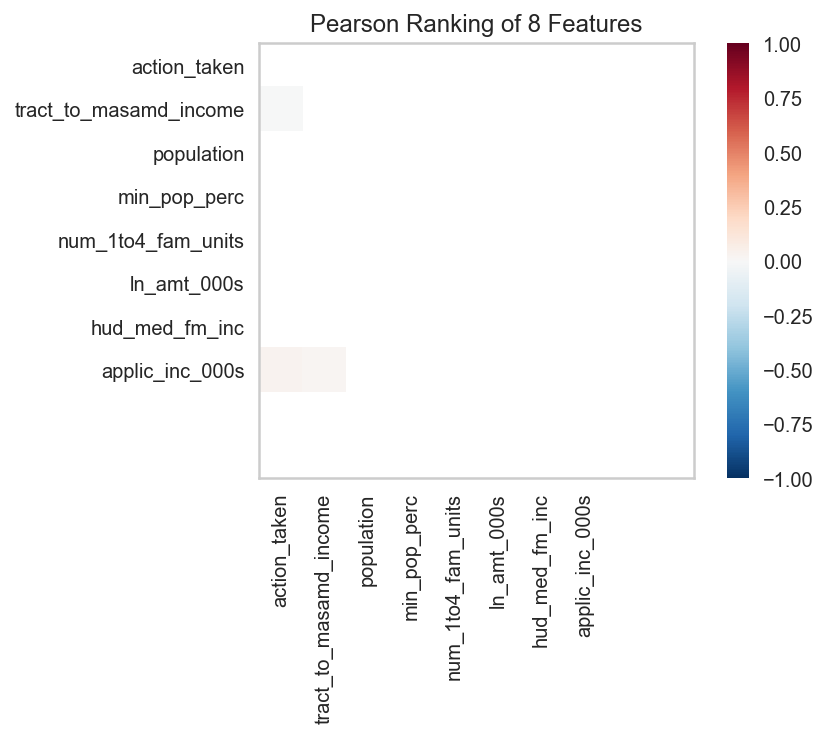

In [137]:
# Instantiate the visualizer with the Pearson ranking algorithm 
visualizer = Rank2D(features=features, algorithm='pearson')

visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof()                   # Draw/show/poof the data
